In [1]:
! hostname
! whoami
! pwd
# ! nvidia-smi

31-34-203.wireless.csail.mit.edu
akarshkumar0101
/Users/akarshkumar0101/exploration-generalization


In [224]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from functools import partial
from einops import rearrange, repeat
import gymnasium as gym
# import gym as gym_old
import gym
from tqdm.auto import tqdm
import cv2
import os
import re
# from ppo import *

import procgen
from procgen import ProcgenEnv

from IPython.display import clear_output

import env_utils
import models
import ppo_rnd
import train
import pretrain
import bc
from pretrain import get_level2files

In [220]:
from env_procgen import make_env
from agent_procgen import E3B

In [111]:
device = 'cpu'
env = make_env('miner', 'ext', 64, 0, 0, 'hard', 0.999, e3b=None, device=device)
action_list = np.array([4, 1, 3, 5, 7])
obs, info = env.reset()
obss, actions = [obs], []
for i in tqdm(range(10000)):
    action = np.random.randint(low=0, high=len(action_list), size=env.num_envs)
    obs, rew, done, info = env.step(action_list[action])
    obss.append(obs)
    actions.append(action)
obss = np.stack(obss)
actions = np.stack(actions)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [137]:
obss.shape, actions.shape

((10001, 64, 64, 64, 3), (10000, 64))

In [293]:
device = 'mps'
batch_size = 1024
e3b = E3B(64, obs_shape=(64, 64, 3), n_actions=5, n_features=100, lmbda=0.1)
e3b.to(device)
opt = torch.optim.Adam(e3b.idm.parameters(), lr=5e-4)#, weight_decay=1e-5)

losses = []

pbar = tqdm(range(1000))
for i_batch in pbar:
    i_step = torch.randint(low=0, high=len(obss)-1, size=(batch_size, ))
    i_env = torch.randint(low=0, high=env.num_envs, size=(batch_size, ))
    obs_now = obss[i_step, i_env]
    obs_nxt = obss[i_step+1, i_env]
    action_now = actions[i_step, i_env]
    obs_now, obs_nxt = torch.from_numpy(obs_now).to(device), torch.from_numpy(obs_nxt).to(device)
    action_now = torch.from_numpy(action_now).to(device)
    logits = e3b.idm(obs_now, obs_nxt)
    
    v1 = e3b.idm.calc_features(obs_now)
    v2 = e3b.idm.calc_features(obs_nxt)
    vlen = (v1-v2).norm(dim=-1).mean()
    
    # if i_batch<20:
    #     loss = (vlen-1.).abs()
    # else:
    ce = torch.nn.functional.cross_entropy(logits, action_now, reduction='none')
    loss = ce.mean()
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    
    pbar.set_postfix(loss=str(loss.item()), vlen=str(vlen.item()))
    losses.append(loss.item())
    # print(torch.tensor([p.std().item() for p in e3b.idm.parameters()]).mean().item())
    # print(e3b.idm.network[0].conv.weight[0,0,0,0].item())
    # print(e3b.idm.network[0].conv.weight.grad[0,0,0,0].item())
    # print()
    

  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

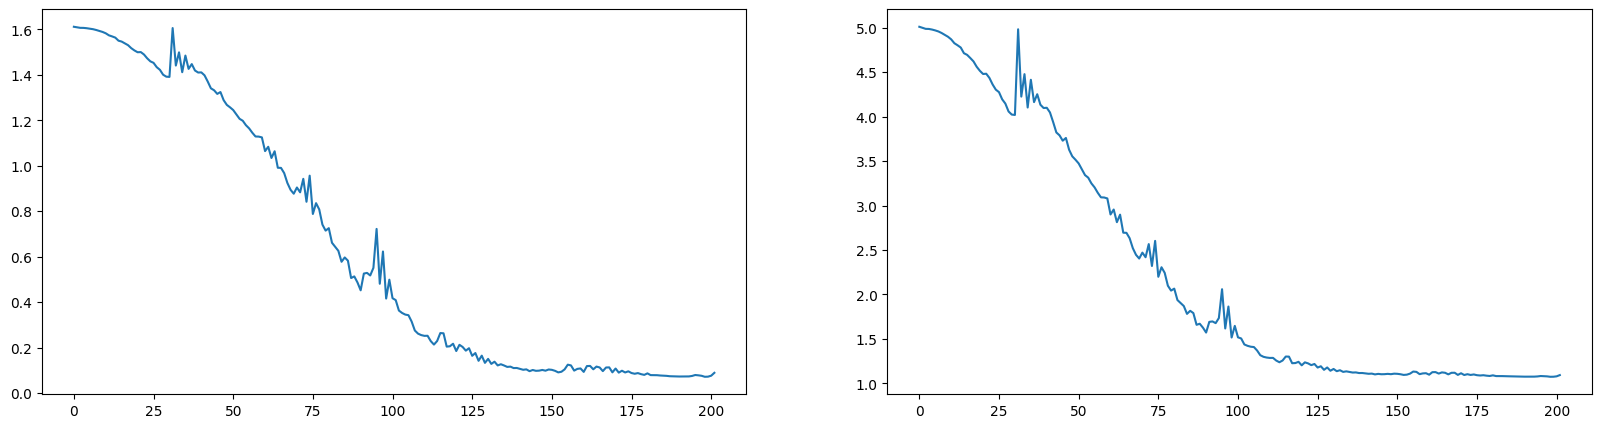

In [277]:
plt.figure(figsize=(20, 5))
plt.subplot(121); plt.plot(np.array(losses))
plt.subplot(122); plt.plot(np.e**np.array(losses))

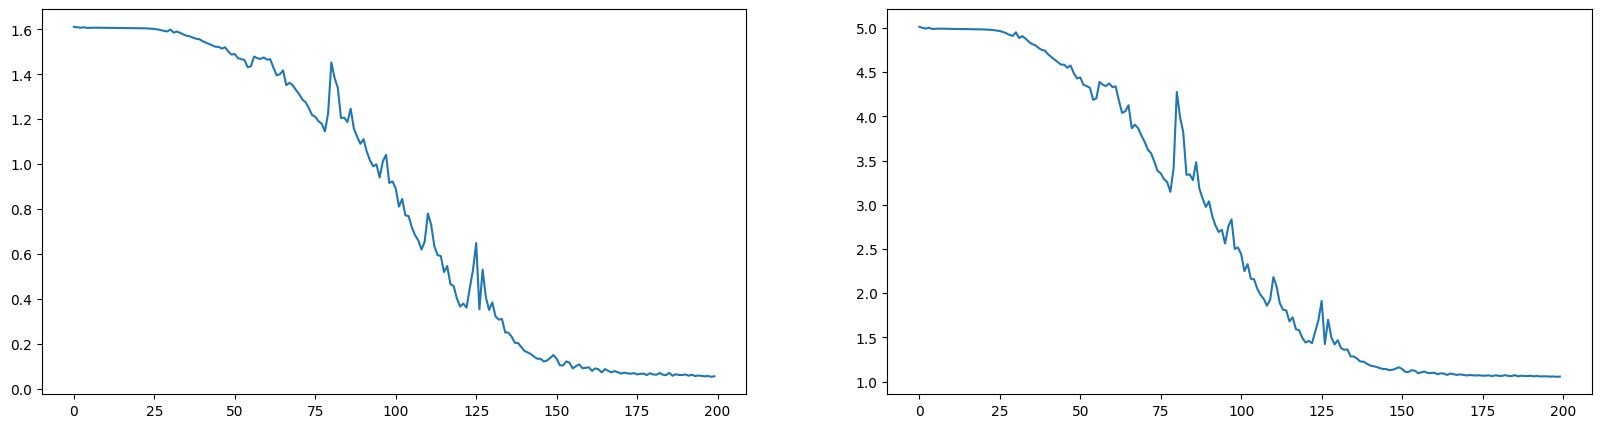

In [267]:
plt.figure(figsize=(20, 5))
plt.subplot(121); plt.plot(np.array(losses))
plt.subplot(122); plt.plot(np.e**np.array(losses))

Action:  0


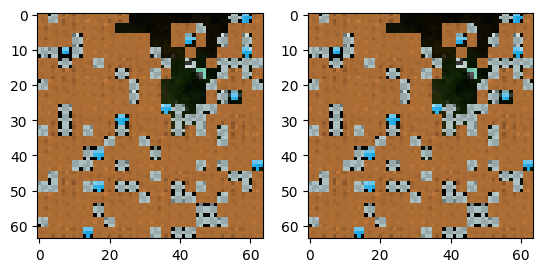

In [233]:
i = 7
plt.subplot(121)
plt.imshow(obs_now[i].cpu().numpy())
plt.subplot(122)
plt.imshow(obs_nxt[i].cpu().numpy())
print('Action: ', action_now[i].item())

(array([43.,  0., 59.,  0.,  0., 40.,  0., 59.,  0., 55.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

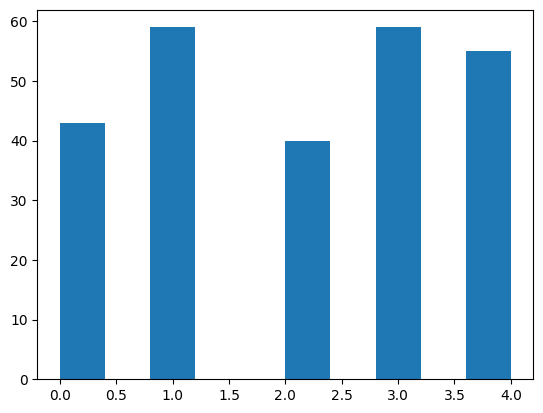

In [ ]:
plt.hist(action_now.cpu().numpy())

In [297]:
from agent_procgen import Agent

In [311]:
device = 'mps'
batch_size = 1024

agent = Agent((64, 64, 6), 5)
agent = agent.to(device)
opt = torch.optim.Adam(agent.parameters(), lr=1e-4)#, weight_decay=1e-5)

losses = []

pbar = tqdm(range(1000))
for i_batch in pbar:
    i_step = torch.randint(low=0, high=len(obss)-1, size=(batch_size, ))
    i_env = torch.randint(low=0, high=env.num_envs, size=(batch_size, ))
    obs_now = obss[i_step, i_env]
    obs_nxt = obss[i_step+1, i_env]
    action_now = actions[i_step, i_env]
    obs_now, obs_nxt = torch.from_numpy(obs_now).to(device), torch.from_numpy(obs_nxt).to(device)
    action_now = torch.from_numpy(action_now).to(device)
    _, _, _, _, logits = agent.get_action_and_value(torch.cat([obs_now, obs_nxt], dim=-1), action=action_now)
    
    # if i_batch<20:
    #     loss = (vlen-1.).abs()
    # else:
    ce = torch.nn.functional.cross_entropy(logits, action_now, reduction='none')
    loss = ce.mean()
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    
    pbar.set_postfix(loss=str(loss.item()))
    losses.append(loss.item())
    # print(torch.tensor([p.std().item() for p in e3b.idm.parameters()]).mean().item())
    # print(e3b.idm.network[0].conv.weight[0,0,0,0].item())
    # print(e3b.idm.network[0].conv.weight.grad[0,0,0,0].item())
    # print()
    

  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

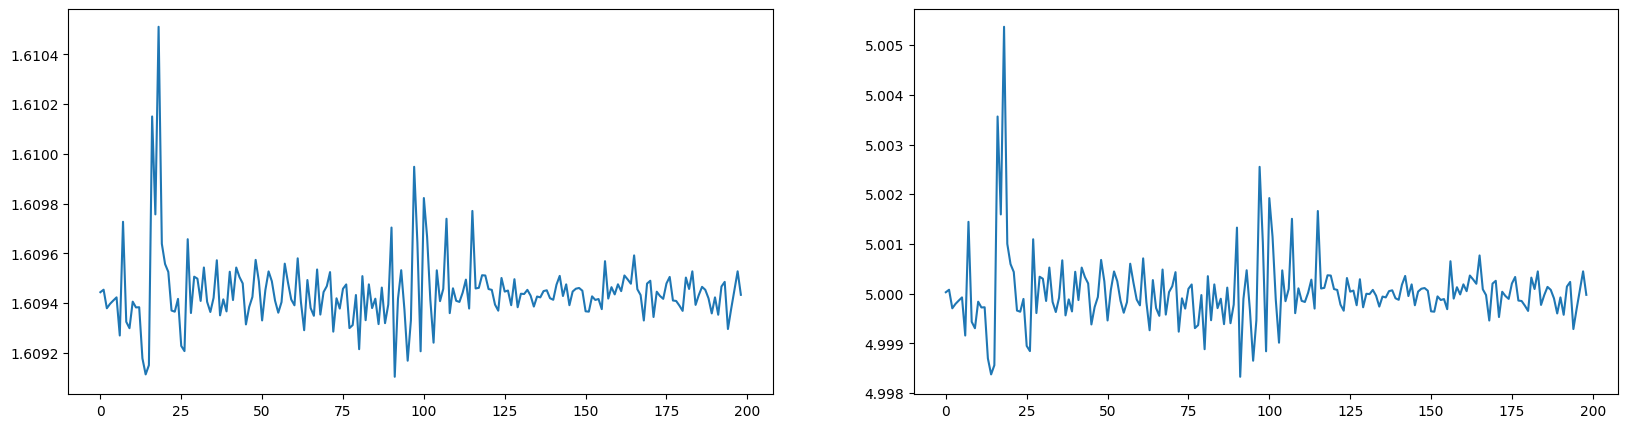

In [312]:
plt.figure(figsize=(20, 5))
plt.subplot(121); plt.plot(np.array(losses))
plt.subplot(122); plt.plot(np.e**np.array(losses))

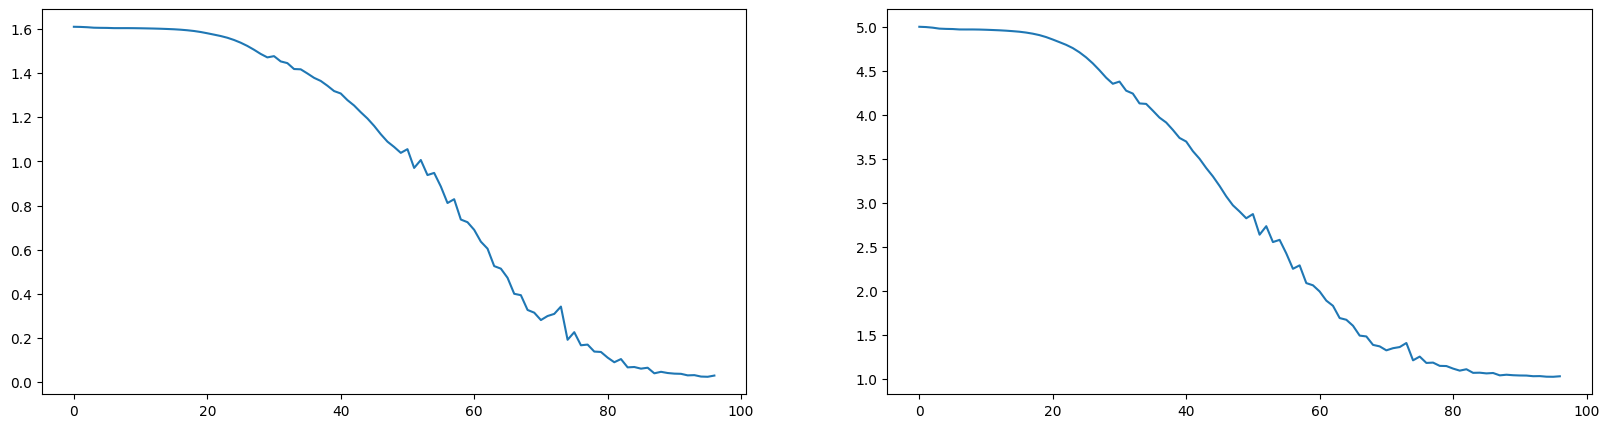

In [308]:
plt.figure(figsize=(20, 5))
plt.subplot(121); plt.plot(np.array(losses))
plt.subplot(122); plt.plot(np.e**np.array(losses))

In [313]:
obs_now.shape, obs_nxt.shape, action_now.shape

(torch.Size([1024, 64, 64, 3]),
 torch.Size([1024, 64, 64, 3]),
 torch.Size([1024]))

right


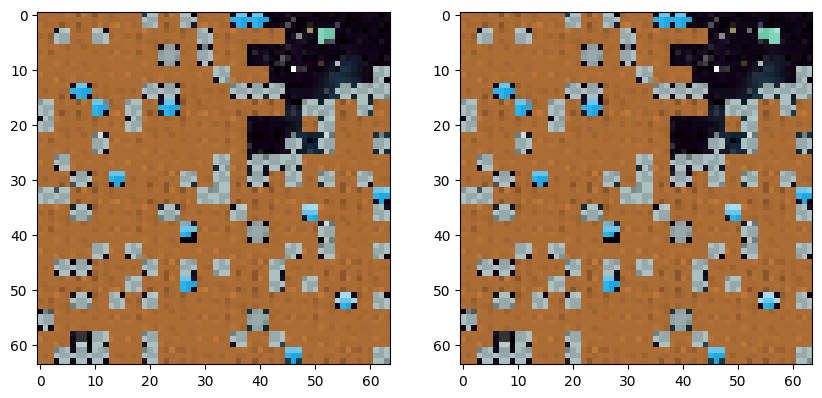

left


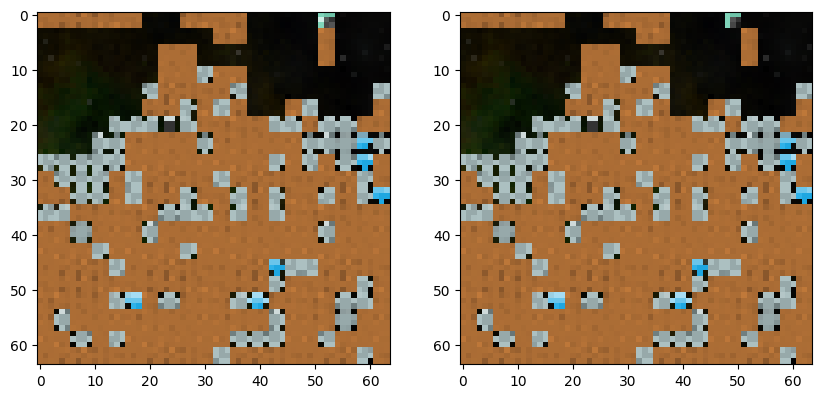

left


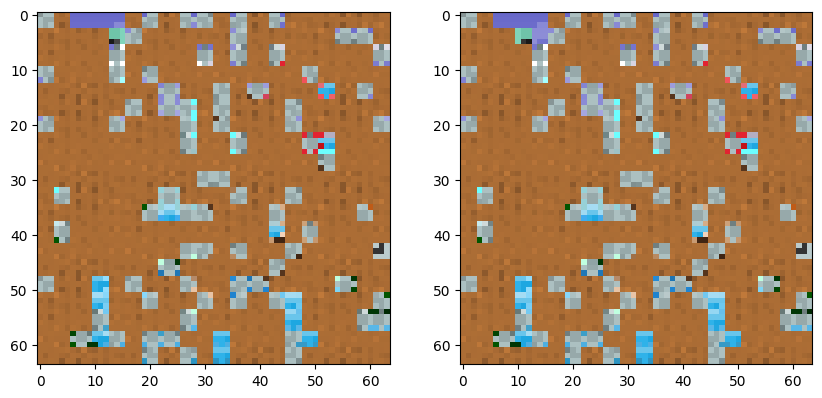

down


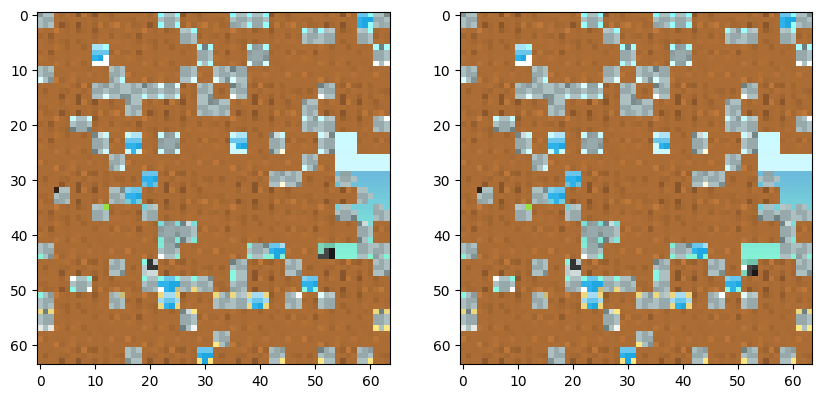

right


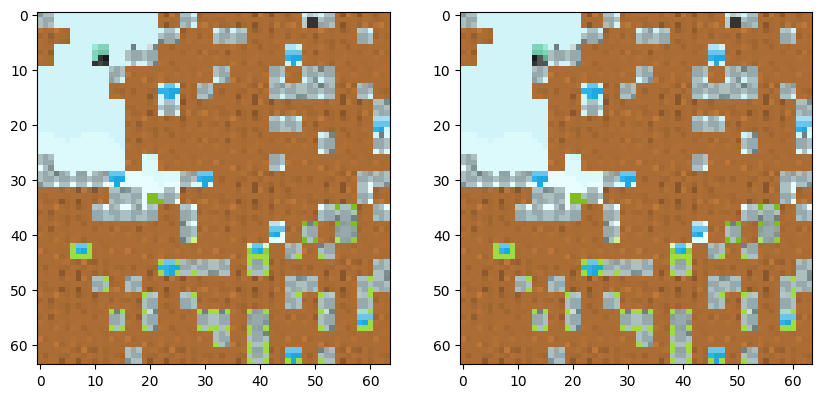

left


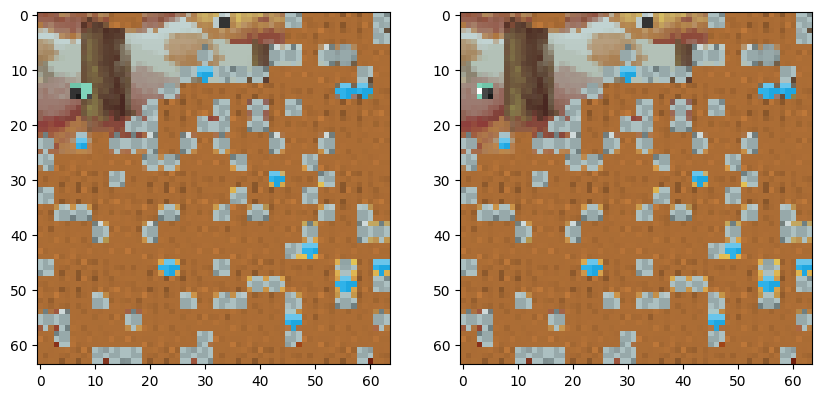

down


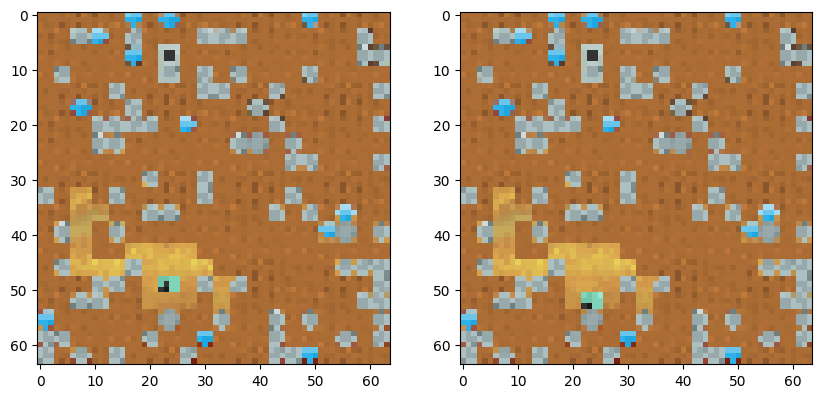

right


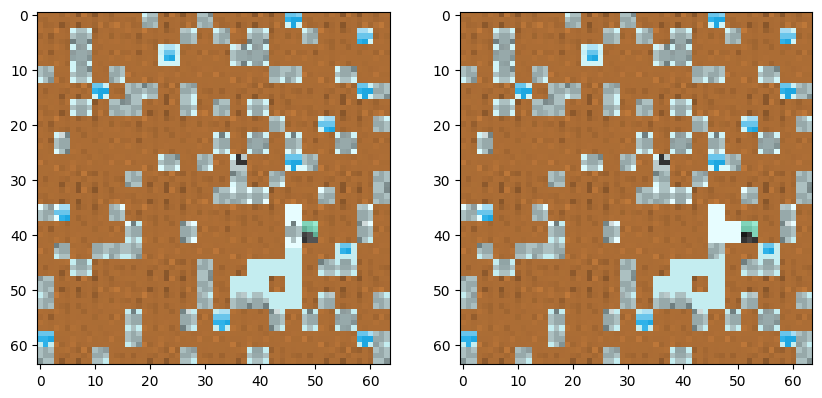

nothing


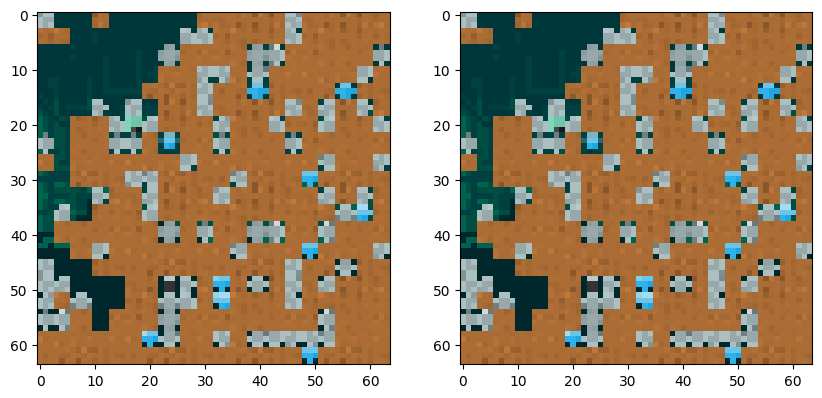

up


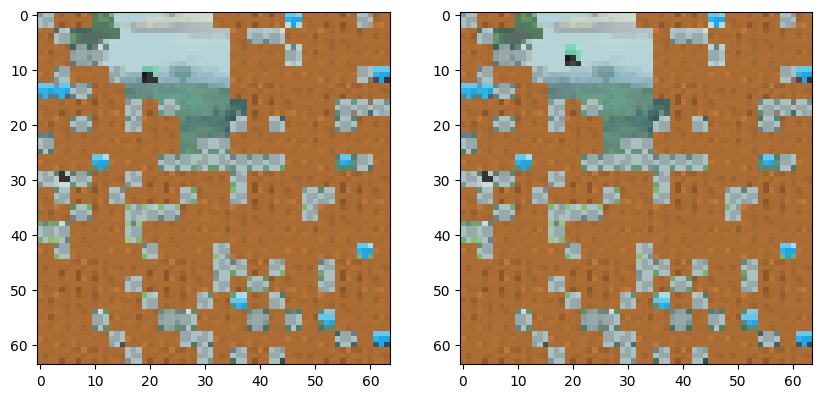

In [317]:
for i in range(10):
    print(['nothing', 'left', 'down', 'up', 'right'][action_now[i].item()])
    plt.figure(figsize=(10, 5))
    plt.subplot(121); plt.imshow(obs_now[i].cpu().numpy())
    plt.subplot(122); plt.imshow(obs_nxt[i].cpu().numpy())
    plt.show()

In [291]:
from ppo_procgen import make_env, Agent
import time

In [292]:
env = make_env('eps', 64, 'miner', 0, 0, 'easy', gamma=0.999)
o = env.reset();
device = 'mps'
agent = Agent(env).to(device)

In [293]:
%%time
start = time.time()
for t in range(256):
    env.step(env.multi_action_space.sample())
dt = time.time()-start
sps = (256*64)/dt
print(f'{dt=} {sps=}')

dt=0.34266018867492676 sps=47814.13348121131
CPU times: user 539 ms, sys: 79.3 ms, total: 618 ms
Wall time: 343 ms


In [294]:
# no eps
dt=0.12113189697265625 sps=135257.52018643322
CPU times: user 326 ms, sys: 49.1 ms, total: 375 ms
Wall time: 121 ms

# eps with .any(axis=-1) call
dt=0.9189369678497314 sps=17829.29686498278
CPU times: user 1.1 s, sys: 69.9 ms, total: 1.17 s
Wall time: 919 ms

# eps with [..., 0] call
dt=0.3300042152404785 sps=49647.850673848996
CPU times: user 512 ms, sys: 64.6 ms, total: 577 ms
Wall time: 330 ms


SyntaxError: invalid syntax (538253356.py, line 2)

In [295]:
obs = torch.randint(low=0, high=255, size=(64, 64, 64, 3))
obs = obs.to(device)

In [296]:
%%time
start = time.time()
for t in range(256):
    agent.temp_out(obs);
dt = time.time()-start
sps = (256*64)/dt
print(f'{dt=} {sps=}')

dt=0.6296169757843018 sps=26022.170033758644
CPU times: user 555 ms, sys: 329 ms, total: 884 ms
Wall time: 630 ms


In [297]:
%%time
start = time.time()

obs1 = np.random.randint(low=0, high=255, size=(64, 64, 64, 3))
obs2 = np.random.randint(low=0, high=255, size=(64, 64, 64, 3))

for t in range(256):
    # a = torch.from_numpy(obs1).to(device).float()
    # b = torch.from_numpy(obs2).to(device).float()
    a.mean(axis=-1)!=b.mean(axis=-1)
    # obs1.mean(axis=-1)!=obs2.mean(axis=-1)
    # obs1[..., 0]!=obs2[..., 0]
    # (obs1!=obs2).any(axis=-1)
    # (obs1!=obs2)[..., 0]
    # (obs1-obs2).sum()
dt = time.time()-start
sps = (256*64)/dt
print(f'{dt=} {sps=}')

dt=0.02696704864501953 sps=607556.2889981257
CPU times: user 25.7 ms, sys: 4.79 ms, total: 30.5 ms
Wall time: 27.1 ms


In [ ]:
# env stepping
# model inference
# model optimization

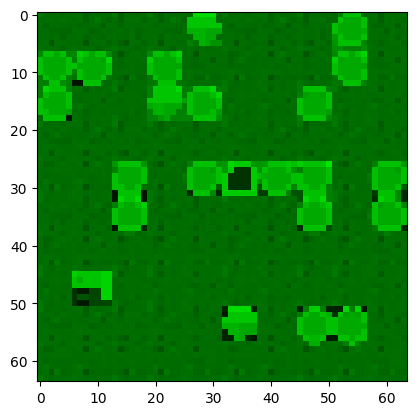

In [266]:
a = o[2].copy()
a[..., [0, 2]] = 0.
plt.imshow(a)

In [287]:
f'{300:06.0f}'

'000300'

In [8]:
args = pretrain.parser.parse_args('--load-dir /data/vision/phillipi/akumar01/unipolicy/exploration_distillation/data --pretrain-obj eps --pretrain-levels 01 --device cuda:0 --lr 1e-3'.split())

In [8]:

env = ProcgenEnv(num_envs=64, env_name='miner', num_levels=1, start_level=0, distribution_mode='easy')

env.reset()
for _ in tqdm(range(10000)):
    env.step(np.array([env.action_space.sample() for _ in range(64)]))

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:04<00:00, 2465.07it/s]


In [9]:
env = env_utils.make_env(64, 'miner', 10000, 10000, 0, distribution_mode='easy', use_backgrounds=True)
env.reset()
for _ in tqdm(range(10000)):
    env.step(env.action_space.sample())

100%|█████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:59<00:00, 168.04it/s]


In [10]:
from stable_baselines3.common.env_util import make_vec_env
# Parallel environments
env = make_vec_env("CartPole-v1", n_envs=4)

In [25]:
env = ProcgenEnv(num_envs=64, env_name='miner', num_levels=1, start_level=0, distribution_mode='easy')

In [32]:
ProcgenEnv(

<function procgen.env.ProcgenEnv(num_envs, env_name, **kwargs)>

In [263]:
net = nn.Sequential(
    nn.Linear(10, 10),
    nn.Linear(10, 10),
)

opt = torch.optim.Adam(net.parameters(), lr=1e-0)

for p in net[1].parameters():
    p.requires_grad_(False)

for i in range(12):
    if i==5:
        for p in net[1].parameters():
            p.requires_grad_(True)
            
    print(f'{i=} {net[0].weight.sum().item()}, {net[1].weight.sum().item()}')
    x = torch.randn(100, 10)
    y = net(x)
    opt.zero_grad()
    y.mean().backward()
    opt.step()

i=0 2.7983882427215576, -0.6098759174346924
i=1 -1.2014873027801514, -0.6098759174346924
i=2 -3.5206995010375977, -0.6098759174346924
i=3 -2.334109306335449, -0.6098759174346924
i=4 -5.771147727966309, -0.6098759174346924
i=5 -9.643922805786133, -0.6098759174346924
i=6 -13.325211524963379, 19.390125274658203
i=7 -13.033836364746094, 39.38874816894531
i=8 -9.130804061889648, 59.43985366821289
i=9 -8.011993408203125, 79.52713775634766
i=10 -8.778507232666016, 99.70854949951172
i=11 -10.30079174041748, 119.99482727050781


In [299]:
for name, p in agent.named_parameters():
    print(name)

network.0.conv.weight
network.0.conv.bias
network.0.res_block0.conv0.weight
network.0.res_block0.conv0.bias
network.0.res_block0.conv1.weight
network.0.res_block0.conv1.bias
network.0.res_block1.conv0.weight
network.0.res_block1.conv0.bias
network.0.res_block1.conv1.weight
network.0.res_block1.conv1.bias
network.1.conv.weight
network.1.conv.bias
network.1.res_block0.conv0.weight
network.1.res_block0.conv0.bias
network.1.res_block0.conv1.weight
network.1.res_block0.conv1.bias
network.1.res_block1.conv0.weight
network.1.res_block1.conv0.bias
network.1.res_block1.conv1.weight
network.1.res_block1.conv1.bias
network.2.conv.weight
network.2.conv.bias
network.2.res_block0.conv0.weight
network.2.res_block0.conv0.bias
network.2.res_block0.conv1.weight
network.2.res_block0.conv1.bias
network.2.res_block1.conv0.weight
network.2.res_block1.conv0.bias
network.2.res_block1.conv1.weight
network.2.res_block1.conv1.bias
network.5.weight
network.5.bias
actor.weight
actor.bias
critic.weight
critic.bias


In [302]:
env = make_env('ext', 64, 'miner', 10, 0, 'easy', 0.999)
env.reset();

In [223]:
import gym
from temp import make_env
env = make_env(64)

os = []
rs = []
env.reset()
for _ in tqdm(range(1)):
    action = np.array([env.action_space.sample() for _ in range(env.num_envs)])
    obs, rew, done, infos = env.step(action)
    # obs[:, :, :, 0] = env.venv.venv.venv.mask_episodic*255.
    
    # os.append(obs)
    # rs.append([info['rew_eps'] for info in infos])


  0%|          | 0/1 [00:00<?, ?it/s]

In [264]:
env.venv.venv.ret_ext, env.venv.venv.ret_eps

(None, None)

In [218]:
env.venv.venv.ret_ext.mean(), env.venv.venv.ret_eps.mean()

(0.125, 11.34375)

In [219]:
obs.shape

(64, 64, 64, 3)

TypeError: can't convert mps:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

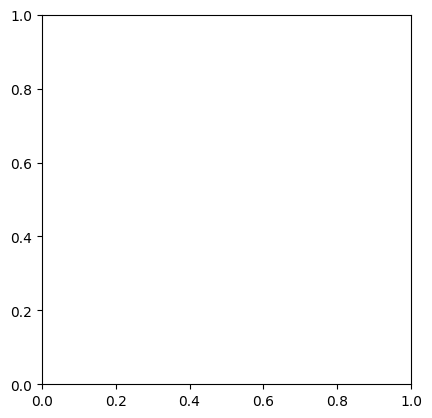

In [225]:
plt.imshow(obs[2])

In [265]:
import temp
from temp import main

In [336]:
args = temp.parser.parse_args('--timesteps 1 --n_steps 20 --n_envs 20 --n_epochs 1'.split())

In [337]:
data = main(args)

 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220/1  [ 0:00:00 < 0:00:00 , ? it/s ]

In [338]:
data

{'args': Namespace(device='cpu', seed=0, track=False, project='exploration-distillation', name='{env}_{level:05d}_{train_obj}_{pretrain_levels}_{pretrain_obj}', obj='ext', env_name='miner', n_envs=20, distribution_mode='easy', n_levels=0, level_start=0, timesteps=1, lr=0.0005, gamma=0.999, gae_lambda=0.95, ent_coef=0.01, n_steps=20, n_epochs=1, batch_size=2048, clip_range=0.2, n_updates=0),
 'venv': <temp.StoreObs at 0x3d002a440>,
 'ppo': <stable_baselines3.ppo.ppo.PPO at 0x3d0147c10>,
 'callback': <temp.MyCallback at 0x2df75b130>}

In [339]:
ppo = data['ppo']

In [341]:
ppo.rollout_buffer

In [431]:
class Block(nn.Module):
    def __init__(self, n_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(n_channels, n_channels, (3, 3), padding='same')
        self.conv2 = nn.Conv2d(n_channels, n_channels, (3, 3), padding='same')
    def forward(self, x):
        res = x
        x = torch.relu(x)
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        return x+res
    
def conv_sequence(n_channels):
    return nn.Sequential(
        nn.LazyConv2d(n_channels, (3, 3), padding='same'),
        nn.MaxPool2d((3, 3), stride=2, padding=(1, 1)),
        Block(n_channels),
        Block(n_channels),
    )
    
class ImpalaCNN(nn.Module):
    def __init__(self, depths=[16,32,32], emb_size=256):
        super().__init__()
        self.net = nn.Sequential(*[conv_sequence(depth) for depth in depths])
        self.lin = nn.LazyLinear(256)
    def forward(self, x):
        x = x / 255.
        x = self.net(x)
        x = rearrange(x, 'b ... -> b (...)')
        x = torch.relu(x)
        print(x.shape)
        x = self.lin(x)
        x = torch.relu(x)
        print(x.shape)
        return x
        
net = ImpalaCNN()
net(torch.randn(8, 3, 64, 64));

torch.Size([8, 2048])
torch.Size([8, 256])


In [434]:
np.sum([p.numel() for p in net.net.parameters()])

97600

In [427]:
np.sum([p.numel() for p in net.parameters()])

622144

In [428]:
from models import Agent
net = Agent(env_utils.make_env(1))

np.sum([p.numel() for p in net.parameters()])

585767

In [340]:
env = temp.make_env(20)
env.reset()

rb = RolloutBuffer(args.n_steps, env.observation_space, env.action_space, args.device, args.gae_lambda, args.gamma, env.num_envs)
rb.reset()
cb = temp.MyCallback(args, env)
cb.init_callback(ppo)

# ppo.collect_rollouts(env, callback=cb, rollout_buffer=rb, n_rollout_steps=args.n_steps)
ppo.collect_rollouts(ppo.env, callback=data['callback'], rollout_buffer=ppo.rollout_buffer, n_rollout_steps=args.n_steps)
ppo.collect_rollouts(ppo.env, callback=cb, rollout_buffer=rb, n_rollout_steps=args.n_steps)


miner

0.0
1.4
40 800
40



ValueError: could not broadcast input array from shape (20,3,64,64) into shape (20,64,64,3)

In [347]:
from stable_baselines3.common.evaluation import evaluate_policy

In [386]:
env = temp.make_env(10)
print(env.venv.venv.nsteps)
evaluate_policy(ppo, env, n_eval_episodes=1, deterministic=False)
print(env.venv.venv.nsteps)


miner
0
239


In [387]:
env.venv.venv.ret_ext, env.venv.venv.ret_eps

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32),
 array([16.,  5., 27., 37.,  0.,  0., 19., 23.,  0., 37.], dtype=float32))

In [389]:
def test(model, env):
    self.policy.set_training_mode(False)

In [249]:
from stable_baselines3.common.buffers import RolloutBuffer
from stable_baselines3.common.callbacks import BaseCallback

In [238]:
env = temp.make_env(128)

miner


In [239]:
env

# Time tests

In [7]:
from procgen import ProcgenEnv
import time

In [10]:
env = ProcgenEnv(64, 'miner')
env.reset();

In [33]:
%%time

start = time.time()
n_iter = 1
for i in range(n_iter):
    for _ in range(256):
        action = np.array([env.action_space.sample() for _ in range(env.num_envs)])
        obs, rew, done, info = env.step(action)

sps = (n_iter*256*env.num_envs)/(time.time()-start)
print(f'SPS: {sps:.0f}')

SPS: 135324
CPU times: user 287 ms, sys: 65.5 ms, total: 352 ms
Wall time: 121 ms


In [520]:
obss = torch.zeros(256, 64, *env.observation_space['rgb'].shape, dtype=torch.uint8)
dones = torch.zeros(256, 64, dtype=torch.bool)
for i in range(256):
    action = np.array([env.action_space.sample() for _ in range(env.num_envs)])
    obs, rew, done, info = env.step(action)
    obss[i] = torch.from_numpy(obs['rgb'])
    dones[i] = torch.from_numpy(done)

In [532]:
a = ((obss[1:]-obss[:-1]).abs()>1e-3).any(dim=-1)
a.shape

torch.Size([255, 64, 64, 64])

In [546]:
mask_start = torch.zeros(64, 64, 64, dtype=torch.bool)
mask_eps = mask_start
for t in range(255):
    mask_eps = mask_eps | a[t]
    mask_eps[dones[t]] = mask_start[dones[t]]

In [547]:
mask_eps.shape

torch.Size([64, 64, 64])

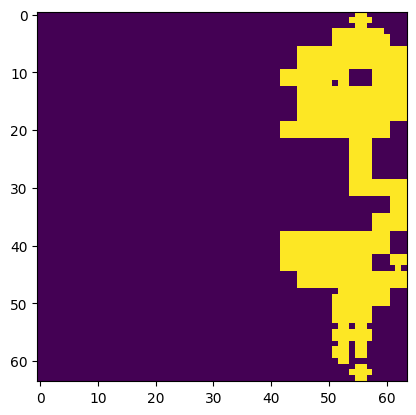

In [549]:
plt.imshow(mask_eps[1])

In [259]:
import gym
from ppo_procgen import VecMinerEpisodicCoverageReward, StoreObs, ReturnTracker

def make_env(obj, num_envs, env_id, num_levels, start_level, distribution_mode, gamma):
    envs = ProcgenEnv(num_envs=num_envs, env_name=env_id, num_levels=num_levels,
                      start_level=start_level, distribution_mode=distribution_mode)
    envs = gym.wrappers.TransformObservation(envs, lambda obs: obs["rgb"])
    envs.observation_space = envs.observation_space['rgb']
    envs.single_action_space = envs.action_space
    envs.single_observation_space = envs.observation_space
    envs.is_vector_env = True
    envs = gym.wrappers.RecordEpisodeStatistics(envs)
    # envs = StoreObs(envs)
    # envs = VecMinerEpisodicCoverageReward(envs, obj)
    # envs = ReturnTracker(envs)
    envs = gym.wrappers.NormalizeReward(envs, gamma=gamma)
    envs = gym.wrappers.TransformReward(envs, lambda reward: np.clip(reward, -10, 10))
    return envs



In [266]:
env = make_env('eps', 64, 'miner', 10, 0, 'hard', 0.99)
env.reset();

In [267]:
n_steps = 10000
start = time.time()
for i in range(n_steps):
    action = np.array([env.action_space.sample() for _ in range(env.num_envs)])
    obs, rew, done, info = env.step(action)
sps = (n_steps*env.num_envs)/(time.time()-start)
print(f'SPS: {sps:9.2f}')

SPS:  86381.60


ProcGen: 147798.46
ProcGen + default wrappers: 134333.95
Procgen + StoreObs: 134854.92
Procgen + VecMinerEpisodicCoverageReward: 17708.16

In [226]:
env = make_env('eps', 64, 'miner', 10, 0, 'easy', 0.99)
env.reset();

In [250]:
n_steps = 1000
obss = torch.zeros(n_steps, env.num_envs, *env.observation_space.shape, dtype=torch.uint8)
dones = torch.zeros(n_steps, env.num_envs, dtype=torch.bool)
start = time.time()
for i in range(n_steps):
    action = np.array([env.action_space.sample() for _ in range(env.num_envs)])
    obs, rew, done, info = env.step(action)
    obss[i] = torch.from_numpy(obs)
    dones[i] = torch.from_numpy(done)
    
mask_start = torch.zeros(64, 64, 64, dtype=torch.bool)
mask_eps = mask_start
a = ((obss[1:]-obss[:-1]).abs()>1e-3).any(dim=-1)
for t in range(255):
    mask_eps = mask_eps | a[t]
    mask_eps[dones[t]] = mask_start[dones[t]]
    
sps = (n_steps*env.num_envs)/(time.time()-start)
print(f'SPS: {sps:9.2f}')

SPS:  71350.85


In [255]:
(25e6/10000)/3600

0.6944444444444444

In [213]:
from ppo_procgen import Agent
agent = Agent(env)

In [222]:
for name, p in agent.named_parameters():
    if name.startswith('critic'):
        p.requires_grad_(False)


In [134]:
os = np.stack(os)[:, 0]
rs = np.array(rs)[:, 0]
os.shape, rs.shape

((100, 64, 64, 3), (100,))

In [135]:
# os[rs==1., :, :, 0] = 0.

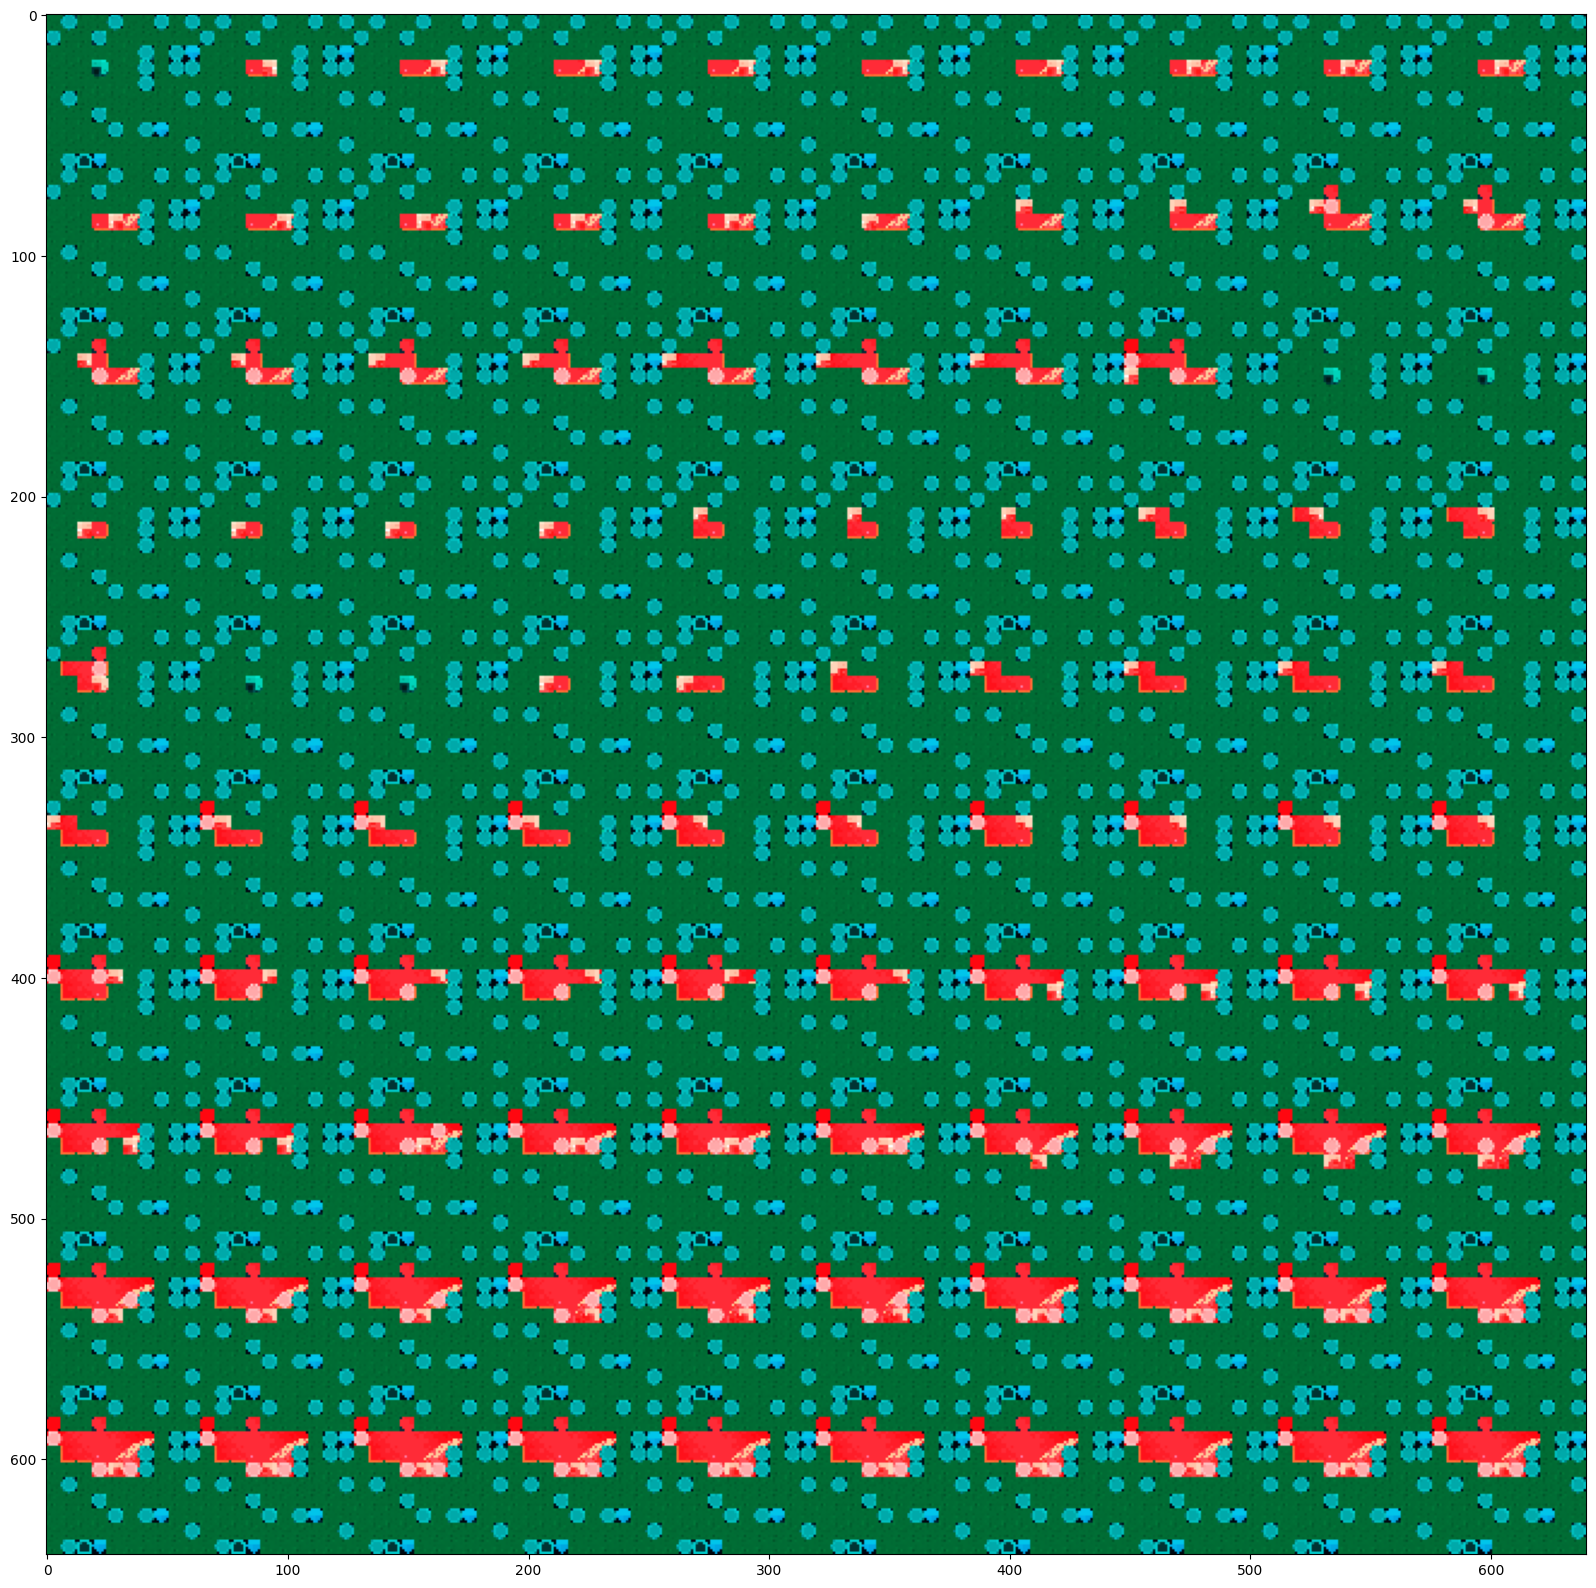

In [136]:
plt.figure(figsize=(20, 20))
a = rearrange(os, '(H W) h w c -> (H h) (W w) c', H=10)
plt.imshow(a)

# E3B

In [311]:
from ppo_procgen import make_env
from einops import repeat

In [312]:
env = make_env('ext', 64, 'miner', 0, 0, 'easy', 0.999)
env.reset();

In [313]:
obs = torch.zeros((256, 64) + env.single_observation_space.shape)
dones = torch.zeros((256, 64))

In [314]:
obs.shape, dones.shape

(torch.Size([256, 64, 64, 64, 3]), torch.Size([256, 64]))

In [315]:
latents = torch.randn(256, 64, 100)
latents.shape

torch.Size([256, 64, 100])

In [316]:
Il = torch.eye(100)/0.1
Cinv = torch.zeros(env.num_envs, 100, 100)
Cinv[:] = Il

for t in range(256):
    v = idm.calc_features(obs[t])[..., :, None] # b, d, 1
    
    u = Cinv @ v
    b = v.mT @ u
    
    Cinv = Cinv - u@u.mT/(1. + b)
    
    Cinv[dones[t].bool()] = Il
    
    rew_eps = b[..., 0, 0]
    break

In [326]:
from ppo_procgen import ConvSequence, layer_init

In [385]:
class IDM(nn.Module):
    def __init__(self, envs, n_features=100):
        super().__init__()
        h, w, c = envs.single_observation_space.shape
        shape = (c, h, w)
        conv_seqs = []
        for out_channels in [16, 32, 32]:
            conv_seq = ConvSequence(shape, out_channels)
            shape = conv_seq.get_output_shape()
            conv_seqs.append(conv_seq)
        conv_seqs += [
            nn.Flatten(),
            nn.ReLU(),
            nn.Linear(in_features=shape[0] * shape[1] * shape[2], out_features=n_features),
            nn.ReLU(),
        ]
        self.network = nn.Sequential(*conv_seqs)
        
        self.idm = nn.Sequential(
            nn.Linear(2*n_features, n_features),
            # nn.ReLU(),
            # nn.Linear(n_features, n_features),
            nn.ReLU(),
            nn.Linear(n_features, env.action_space.n),
        )

    def calc_features(self, x):
        hidden = self.network(x.permute((0, 3, 1, 2)) / 255.0)  # "bhwc" -> "bchw"
        return hidden
    
    def forward(self, obs, next_obs):
        l1 = self.calc_features(obs)
        l2 = self.calc_features(next_obs)
        l = torch.cat([l1, l2], dim=-1)
        logits = self.idm(l)
        return logits

class E3B(nn.Module):
    def __init__(self, envs, n_features=100):
        super().__init__()
        self.idm = IDM(envs, n_features)
    
        self.Il = nn.Parameter(torch.eye(100)/0.1) # d, d
        self.Cinv = nn.Parameter(torch.zeros(env.num_envs, 100, 100)) # b, d, d
        self.Il.requires_grad_(False)
        self.Cinv.requires_grad_(False)
        
        self.Cinv[:] = Il

    def calc_rew(self, obs, done=None):
        """
        obs should be of shape (n_envs, *obs_shape)
        done should be of shape (n_envs, ) signaling if this obs is for a new episode
        """
        if done is not None:
            self.Cinv[done.bool()] = Il
        v = self.idm.calc_features(obs)[..., :, None] # b, d, 1
        u = self.Cinv @ v # b, d, 1
        b = v.mT @ u # b, 1, 1
        self.Cinv[:] = self.Cinv - u@u.mT/(1. + b) # b, d, d
        rew_eps = b[..., 0, 0].detach()
        return rew_eps
        
e3b = E3B(env, 100)

In [386]:
obs[0].shape

torch.Size([64, 64, 64, 3])

In [393]:
e3b.calc_rew(obs[0], done=None)

tensor([0.2409, 0.2408, 0.2411, 0.2409, 0.2409, 0.2409, 0.2409, 0.2409, 0.2411,
        0.2411, 0.2409, 0.2410, 0.2410, 0.2409, 0.2409, 0.2410, 0.2410, 0.2410,
        0.2409, 0.2409, 0.2408, 0.2411, 0.2409, 0.2412, 0.2410, 0.2410, 0.2409,
        0.2409, 0.2409, 0.2410, 0.2409, 0.2409, 0.2410, 0.2409, 0.2410, 0.2409,
        0.2409, 0.2409, 0.2410, 0.2409, 0.2412, 0.2408, 0.2409, 0.2410, 0.2409,
        0.2410, 0.2409, 0.2409, 0.2409, 0.2409, 0.2409, 0.2409, 0.2410, 0.2410,
        0.2410, 0.2409, 0.2410, 0.2410, 0.2409, 0.2409, 0.2409, 0.2409, 0.2410,
        0.2410])

In [395]:
e3b.calc_rew(torch.randn(64, 64, 64, 3), done=None)

tensor([0.1645, 0.1642, 0.1647, 0.1645, 0.1646, 0.1643, 0.1644, 0.1644, 0.1648,
        0.1646, 0.1645, 0.1644, 0.1642, 0.1645, 0.1645, 0.1643, 0.1643, 0.1646,
        0.1645, 0.1644, 0.1642, 0.1645, 0.1644, 0.1645, 0.1645, 0.1645, 0.1644,
        0.1646, 0.1645, 0.1645, 0.1644, 0.1644, 0.1642, 0.1644, 0.1646, 0.1645,
        0.1644, 0.1644, 0.1645, 0.1643, 0.1644, 0.1645, 0.1644, 0.1646, 0.1642,
        0.1644, 0.1645, 0.1642, 0.1646, 0.1644, 0.1642, 0.1646, 0.1645, 0.1645,
        0.1643, 0.1643, 0.1645, 0.1644, 0.1644, 0.1646, 0.1644, 0.1647, 0.1643,
        0.1647])

In [341]:
e3b.idm.calc_features(obs[0]).shape

torch.Size([64, 100])

In [342]:
idm(obs[0], obs[1]);

In [323]:
np.sum([p.numel() for p in idm.parameters()])

324115

In [336]:
x = torch.randn(256, 64, 64, 64, 3)

In [337]:
%%timeit
x.to('mps')

22.4 ms ± 558 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [338]:
%%timeit
for i in range(256):
    x[t].to('mps')

46.2 ms ± 533 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


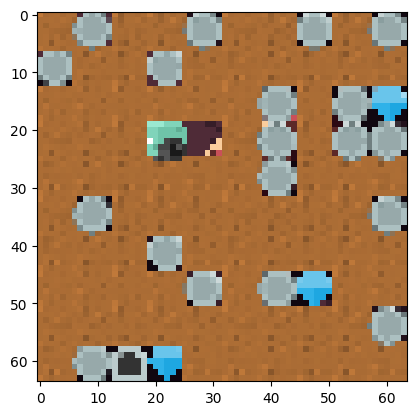

In [51]:
plt.imshow(obs[1])

In [440]:
A = torch.randn(10, 1000, 1000)
B = torch.randn(10, 1000, 1000)
Am = A.to('mps')
Bm = B.to('mps')

In [441]:
%%time
for i in range(100):
    c = A@B;
print(c.sum().item())

-61426.15625
CPU times: user 2.48 s, sys: 82.5 ms, total: 2.56 s
Wall time: 1.29 s


In [442]:
%%time
for i in range(100):
    c = Am@Bm
print(c.sum().item())

-61426.15234375
CPU times: user 45.6 ms, sys: 256 ms, total: 301 ms
Wall time: 671 ms


In [ ]:
64, 256, fs, 64, 64, 3

In [448]:
(64*256*64*64*3*30)/1e6

6039.79776

In [9]:
args

Namespace(device='cuda:0', seed=0, track=False, project='exploration-distillation', name='distill_{env}_{pretrain_levels:05d}_{pretrain_obj}', load_dir='/data/vision/phillipi/akumar01/unipolicy/exploration_distillation/data', env='miner', pretrain_levels=1, pretrain_obj='eps', lr=0.001, coef_entropy=0, batch_size=4096, n_steps=50000, n_viz_fast=50000, n_viz_slow=30)

In [14]:
level2files = pretrain.get_level2files(args)
level2files = {k: [v[-1]] for k, v in level2files.items()}
file = level2files[0][0]
print(level2files)
print(file)

{0: ['/data/vision/phillipi/akumar01/unipolicy/exploration_distillation/data/miner_00000_eps/agent_02440.pt']}
/data/vision/phillipi/akumar01/unipolicy/exploration_distillation/data/miner_00000_eps/agent_02440.pt


In [27]:
env = env_utils.make_env(1, env_name=f'procgen-{args.env}-v0', level_id=0)
agent = models.Agent(env)
agent = agent.to(args.device)
opt = torch.optim.Adam(agent.parameters(), lr=1e-2)
a, b = [], []
envs, x_train, y_train, y_probs_train = None, None, None, None
pbar = tqdm(range(3000))
for i in pbar:
    if i%30==0:
        envs, x_train, y_train, y_probs_train = pretrain.collect_batch(args.env, level2files, n_agents=1, n_envs=100, n_steps=1000, device=args.device)
        x_train = rearrange(x_train, '... fs h w c -> (...) fs h w c')
        y_train = rearrange(y_train, '... -> (...)')
        y_probs_train = rearrange(y_probs_train, '... l -> (...) l')

        # randomly shuffle x, y, y_probs
        # idxs = torch.randperm(len(x_train))
        # x_train, y_train, y_probs_train = x_train[idxs], y_train[idxs], y_probs_train[idxs]

    idxs_batch = torch.randperm(len(x_train))[:args.batch_size]
    x_batch, y_batch, y_probs_batch = x_train[idxs_batch], y_train[idxs_batch], y_probs_train[idxs_batch]
    x_batch, y_batch, y_probs_batch = x_batch.to(args.device), y_batch.to(args.device), y_probs_batch.to(args.device)

    dist, _, _ = agent.get_dist_and_values(x_batch)
    ce = nn.functional.cross_entropy(dist.logits, y_probs_batch, reduction='none')
    loss = ce.mean()
    opt.zero_grad()
    loss.backward()
    opt.step()


    a.append(loss.item())
    b.append(torch.distributions.Categorical(probs=y_probs_batch).entropy().mean().item())
    pbar.set_postfix(loss=a[-1], gt_entropy=b[-1])


torch.Size([1000000, 4, 64, 64, 3]) torch.Size([1000000]) torch.Size([1000000, 5])


In [28]:
y_probs_batch.shape

torch.Size([1000000, 4, 64, 64, 3])

100%|██████████| 2000/2000 [04:40<00:00,  7.12it/s, gt_entropy=0.573, loss=0.65] 


(0.4, 1.5)

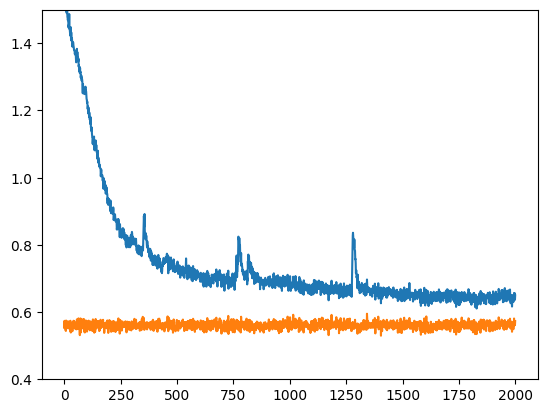

In [33]:
plt.plot(a)
plt.plot(b)


  9%|▉         | 181/2000 [00:24<04:08,  7.33it/s, gt_entropy=0.673, loss=0.698]

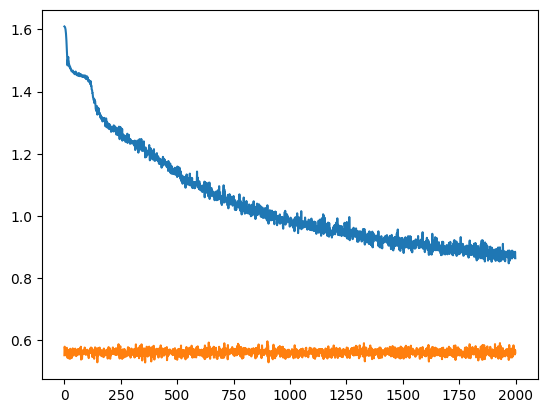

In [42]:
x_train.shape, y_train.shape

(torch.Size([1, 1000, 1, 4, 64, 64, 3]), torch.Size([1, 1000, 1]))

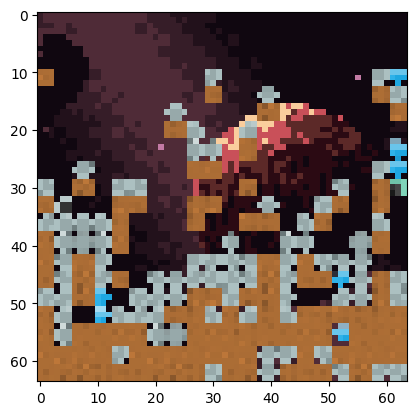

In [43]:
plt.imshow(x_train[0, -1, 0, -1].cpu().numpy())

In [99]:
def collect_rollout(env, agent, n_steps, device=None):
    x, y = [], []
    agent = agent.to(device).eval()
    obs, _ = env.reset() # or just step randomly first time
    for step in range(n_steps):
        obs = torch.from_numpy(obs)
        with torch.no_grad():
            action, _, _, _, _ = agent.get_action_and_value(obs.to(device))
        x.append(obs)
        y.append(action.cpu())
        obs, reward, term, trunc, info = env.step(action.tolist())
    return torch.stack(x), torch.stack(y)

def collect_batch(env_name, level2files, n_agents, n_steps, device=None):
    env = env_utils.make_env(1, env_name=f'procgen-{env_name}-v0', level_id=0)
    agent = models.Agent(env)
    
    lf = [(level, file) for level, files in level2files.items() for file in files]
    lf = [lf[i] for i in np.random.choice(len(lf), size=n_agents)]
    
    envs, x, y = [], [], []
    for level, file in tqdm(lf):
        agent.load_state_dict(torch.load(file))
        env = env_utils.make_env(4, env_name=f'procgen-{env_name}-v0', level_id=level)
        xi, yi = collect_rollout(env, agent, n_steps, device=device)
        envs.append(env)
        x.append(xi)
        y.append(yi)
    return envs, torch.stack(x), torch.stack(y)
    
envs, x, y = collect_batch(args.env, level2files, 10, 1000, args.device)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:18<00:00,  1.86s/it]


In [100]:
x.shape, y.shape, x.numel()/1e9

(torch.Size([10, 1000, 4, 4, 64, 64, 3]), torch.Size([10, 1000, 4]), 1.96608)

In [107]:
[e.envs[0].past_returns_eps for e in envs]

[[211.0, 267.0],
 [238.0, 243.0],
 [148.0],
 [292.0, 206.0, 16.0],
 [148.0],
 [56.0, 266.0, 287.0],
 [264.0],
 [240.0, 267.0],
 [292.0, 298.0],
 [304.0]]

In [104]:
envs[-1].envs[0].past_traj_obs.shape

(724, 64, 64, 3)

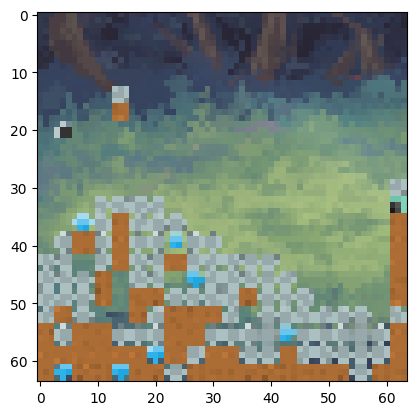

In [105]:
plt.imshow(envs[-1].envs[0].past_traj_obs[-1])

In [268]:

# env = eval_performance(agent, list(level2files.keys()), device=args.device)
# a = [e.past_returns_eps for e in env.envs]
# b = [e.past_returns_ext for e in env.envs]
# a, b

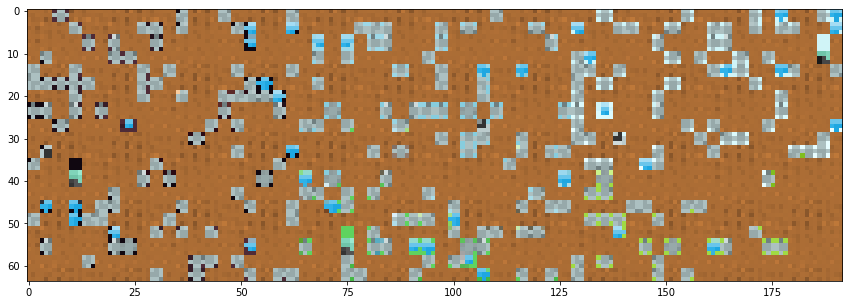

In [165]:
env = env_utils.make_env(3, level_id=[0, 1, 2])
obs, info = env.reset()
obs, rew, term, trunc, info = env.step([1, 1, 1])
plt.figure(figsize=(20, 5))
plt.imshow(rearrange(obs[:, -1], 'n h w c -> h (n w) c'))

In [181]:
env = env_utils.make_env(3, level_id=[0, 1, 2], seed=1, reward_fn='eps')
obs, info = env.reset()
rews = []
for i in range(1200):
    obs, rew, term, trunc, info = env.step(env.action_space.sample())
    rews.append(rew)

In [161]:
pto = env.envs[0].past_traj_obs
pto.shape

(102, 64, 64, 3)

In [162]:

def temp1(o):
    return (o.std(axis=0).mean(axis=-1)>0).sum()/env.envs[0].first_obs.mean(axis=-1).size

def temp2(pto):
    heatmap = np.sign(np.abs(np.diff(pto.mean(axis=-1), axis=0))).sum(axis=0)
    return (heatmap>0).sum()/heatmap.size


# plt.imshow(heatmaps.mean(axis=0))
# plt.colorbar()

In [163]:
%%timeit
temp1(pto)

6.47 ms ± 834 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [164]:
%%timeit
temp2(pto)

8.82 ms ± 70.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [106]:
heatmap = pto2heatmap(pto)

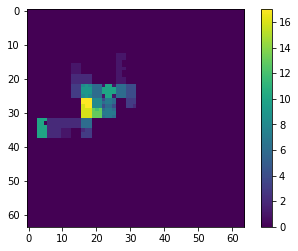

In [105]:
plt.imshow(heatmap)
plt.colorbar()
plt.show()

In [ ]:
def get_zero_shot(agent, level_id, n_steps, device=None):
    agent = agent.to(device)
    obs, _ = env.reset() # or just step randomly first time
    for step in range(n_steps):
        obs = torch.from_numpy(obs)
        with torch.no_grad():
            action, _, _, _, _ = agent.get_action_and_value(obs.to(device))
        obs, reward, term, trunc, info = env.step(action.tolist())
    # env.past_returns_ext

In [186]:
'hello_{hi:.2f}'.format(hi=8, fewa=3)

'hello_8.00'

In [204]:
from train import parser
args = parser.parse_args('')

In [36]:
env = env_utils.make_env(10, level_id=0, async_=False, reward_fn='eps')

In [37]:

obs, info = env.reset()
obs, rew, term, trunc, info = env.step(env.action_space.sample())


In [38]:
info['rew_ext']

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [39]:
info['rew_eps']

array([1., 1., 1., 1., 1., 1., 1., 1., 0., 1.])

In [215]:
o = obs[0, 0]
o.shape

(64, 64, 3)

In [251]:
from einops import einsum

In [300]:
def o2latent(o):
    return torch.randn(100)
latent = torch.randn(10, 100)[..., :, None]

Cinv = torch.zeros(10, 100, 100)
Cinv[:] = 1/10. * torch.eye(100)

u = Cinv @ latent
bonus = (latent.mT @ u)
# print(Cinv.shape, latent.shape)
# print(u.shape, bonus.shape)

Cinv = Cinv - 1./(1.+bonus) * u @ u.mT




In [309]:
rews = torch.rand(10, 1000)
dones = torch.rand(10, 1000)<.03

In [ ]:
def temp(rew, done):
    rewsum = torch.zeros_like(rews)
    rets = []
    b, t = rew.shape
    for i in range(t):
        rewsum += rew[:, i]

        

In [328]:
for i in range(32):
    a = 'python train.py --level {i:03d} --train-obj eps --gamma 0.90 --ent-coef 1e-1 --total-timesteps 4e7 --device cuda --track --project exploration-distillation-data --name {env}_{level:05d}_{train_obj}'
    print(a)

KeyError: 'env'

In [344]:
servers = [
    'visiongpu21.csail.mit.edu',
    'visiongpu22.csail.mit.edu',
    'visiongpu51.csail.mit.edu',
    'visiongpu52.csail.mit.edu',
    'visiongpu53.csail.mit.edu',
    'visiongpuws01.csail.mit.edu',
    # 'visiongpuws02.csail.mit.edu',
]

from subprocess import check_output
for server in tqdm(servers):
    print('----------')
    print(server)
    out = check_output(f'ssh {server} "pgrep python -u akumar01"', shell=True).decode()
    print(len(out.split('\n'))-1)

  0%|          | 0/6 [00:00<?, ?it/s]

----------
visiongpu21.csail.mit.edu


 17%|█▋        | 1/6 [00:01<00:05,  1.14s/it]

12
----------
visiongpu22.csail.mit.edu


 33%|███▎      | 2/6 [00:02<00:04,  1.17s/it]

12
----------
visiongpu51.csail.mit.edu


 50%|█████     | 3/6 [00:03<00:03,  1.22s/it]

15
----------
visiongpu52.csail.mit.edu


 67%|██████▋   | 4/6 [00:04<00:02,  1.19s/it]

25
----------
visiongpu53.csail.mit.edu


 83%|████████▎ | 5/6 [00:06<00:01,  1.38s/it]

30
----------
visiongpuws01.csail.mit.edu


100%|██████████| 6/6 [00:07<00:00,  1.21s/it]

5


In [282]:
%%timeit
einsum(latent, Cinv, latent, 'b i, b i j , b j -> b')

244 µs ± 46.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [285]:
%%timeit
(latent[..., None, :] @ Cinv @ latent[..., :, None])[:, 0, 0]

38.5 µs ± 3.91 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [284]:
%%timeit
torch.einsum('b i, b i j , b j -> b', latent, Cinv, latent)

220 µs ± 48.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


<function einops.einops.einsum(*tensors_and_pattern: Union[~Tensor, str]) -> ~Tensor>

  0%|          | 0/20 [00:00<?, ?it/s]

-----------
1.0


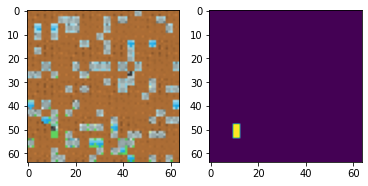

  5%|▌         | 1/20 [00:00<00:04,  4.43it/s]

-----------
1.0


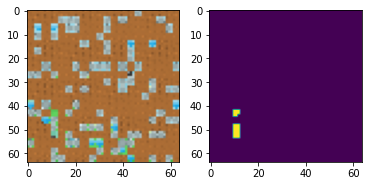

 10%|█         | 2/20 [00:00<00:03,  4.50it/s]

-----------
1.0


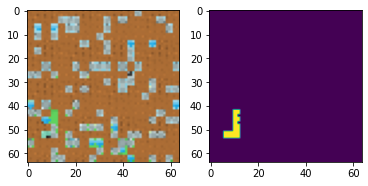

 15%|█▌        | 3/20 [00:00<00:03,  4.50it/s]

-----------
1.0


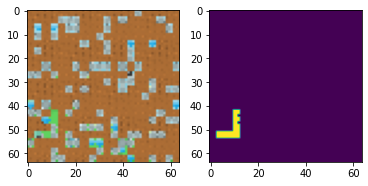

 20%|██        | 4/20 [00:00<00:03,  4.59it/s]

-----------
0.0


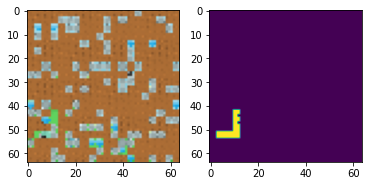

 25%|██▌       | 5/20 [00:01<00:03,  4.59it/s]

-----------
0.0


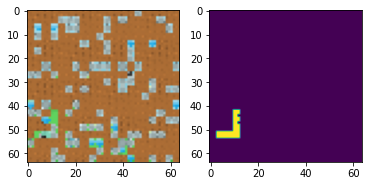

 30%|███       | 6/20 [00:01<00:03,  4.44it/s]

-----------
1.0


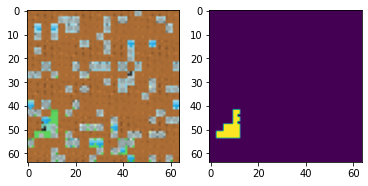

 35%|███▌      | 7/20 [00:01<00:02,  4.70it/s]

-----------
1.0


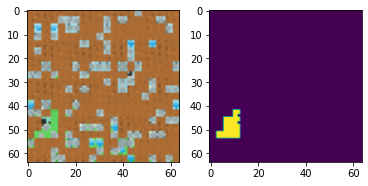

 40%|████      | 8/20 [00:01<00:02,  4.80it/s]

-----------
0.0


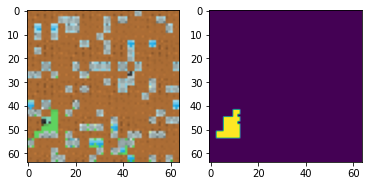

 45%|████▌     | 9/20 [00:01<00:02,  4.96it/s]

-----------
1.0


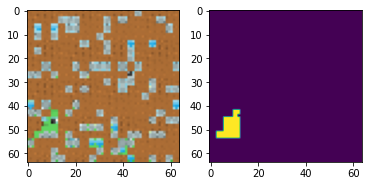

 50%|█████     | 10/20 [00:02<00:02,  4.99it/s]

-----------
1.0


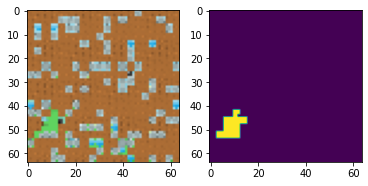

 55%|█████▌    | 11/20 [00:02<00:01,  5.01it/s]

-----------
0.0


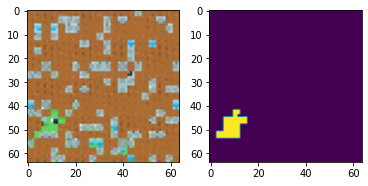

 60%|██████    | 12/20 [00:02<00:02,  3.75it/s]

-----------
0.0


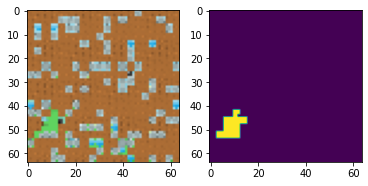

 65%|██████▌   | 13/20 [00:02<00:01,  4.16it/s]

-----------
0.0


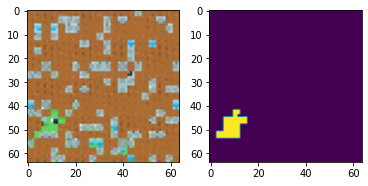

 70%|███████   | 14/20 [00:03<00:01,  4.41it/s]

-----------
1.0


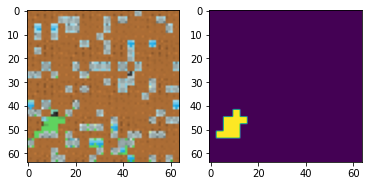

 75%|███████▌  | 15/20 [00:03<00:01,  4.51it/s]

-----------
1.0


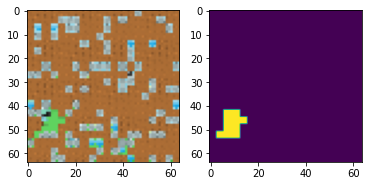

 80%|████████  | 16/20 [00:03<00:00,  4.30it/s]

-----------
1.0


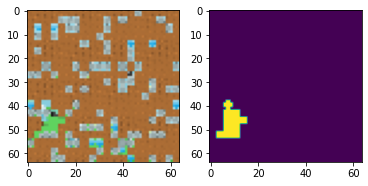

 85%|████████▌ | 17/20 [00:03<00:00,  4.65it/s]

-----------
0.0


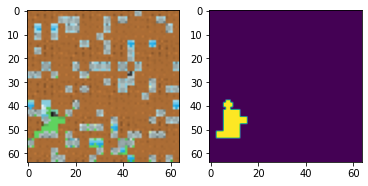

 90%|█████████ | 18/20 [00:03<00:00,  4.78it/s]

-----------
0.0


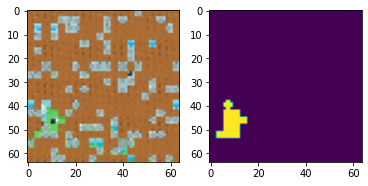

 95%|█████████▌| 19/20 [00:04<00:00,  4.85it/s]

-----------
0.0


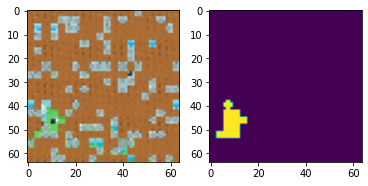

100%|██████████| 20/20 [00:04<00:00,  4.62it/s]

CPU times: user 7.57 s, sys: 1.12 s, total: 8.69 s
Wall time: 4.34 s


In [158]:
%%time
np.random.seed(5)
env = env_utils.make_env(1, level_id=1, async_=False, reward_fn='eps')
obs, info = env.reset()
for i in tqdm(range(20)):
    obs, r, term, trunc, info = env.step(env.action_space.sample())
    print('-----------')
    print(r.item())
    plt.subplot(121)
    plt.imshow(obs[0, -1])
    plt.subplot(122)
    plt.imshow(env.envs[0].mask)
    plt.show()

In [160]:
env.envs[0].running_return

11.0

In [139]:
env = env_utils.make_env(2, async_=True, reward_fn='eps')

In [148]:
env = env_utils.make_env(1)
agent = models.Agent(env)
# agent.load_state_dict(torch.load(f"data/distill_miner_{32:05d}_ext/agent.pt"))
env = eval_zero_shot(agent, n_envs, 3000, device='cuda:1')
rets_random = [np.array(e.past_returns[1:]) for e in env.envs]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [02:57<00:00, 16.91it/s]


100%|██████████| 1000/1000 [00:04<00:00, 240.85it/s]


In [362]:
a, b

([[51.0, 10.0, 50.0, 6.0, 7.0, 80.0],
  [2.0, 6.0, 11.0, 6.0, 9.0, 10.0, 5.0],
  [5.0, 18.0, 52.0, 22.0, 4.0, 4.0, 6.0, 3.0, 6.0, 6.0, 2.0, 8.0, 8.0]],
 [[2.0, 0.0, 3.0, 0.0, 0.0, 1.0],
  [0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0],
  [0.0, 1.0, 3.0, 3.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]])

In [104]:

n_envs = 256

env = env_utils.make_env(1)
agent = models.Agent(env)
agent.load_state_dict(torch.load(f"data/distill_miner_{32:05d}_ext/agent.pt"))
env = eval_zero_shot(agent, n_envs, 3000, device='cuda:1')
rets_ext = [np.array(e.past_returns[1:]) for e in env.envs]

env = env_utils.make_env(1)
agent = models.Agent(env)
agent.load_state_dict(torch.load(f"data/distill_miner_{32:05d}_int/agent.pt"))
env = eval_zero_shot(agent, n_envs, 3000, device='cuda:1')
rets_int = [np.array(e.past_returns[1:]) for e in env.envs]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [02:54<00:00, 17.24it/s]


In [150]:
mean_rets_ext = np.array([i.mean() for i in rets_ext])
mean_rets_int = np.array([i.mean() for i in rets_int])
mean_rets_random = np.array([i.mean() for i in rets_random])
diff = mean_rets_ext-mean_rets_int

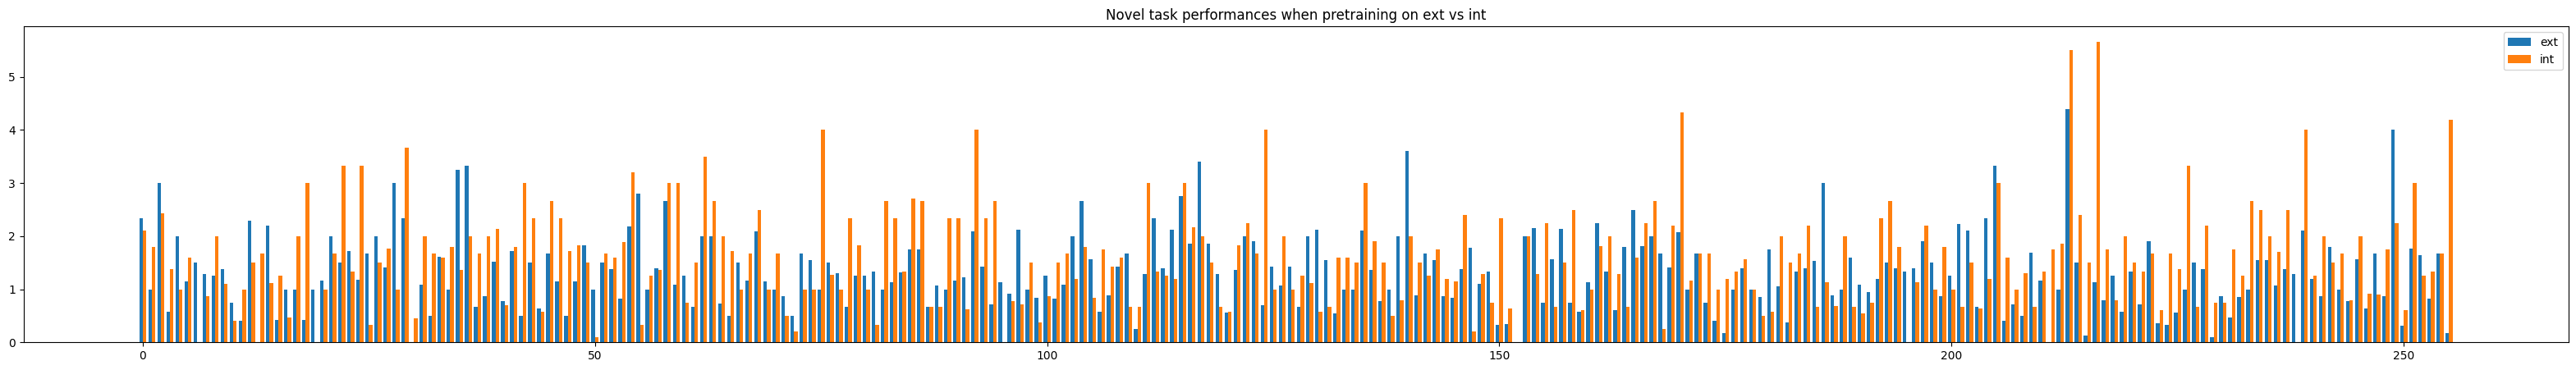

In [130]:
plt.figure(figsize=(40, 5))
plt.title('Novel task performances when pretraining on ext vs int')
x = np.arange(len(rets_ext))
plt.bar(x-0.2, mean_rets_ext, .4, label='ext')
plt.bar(x+0.2, mean_rets_int, .4, label='int')
plt.legend()
plt.show()

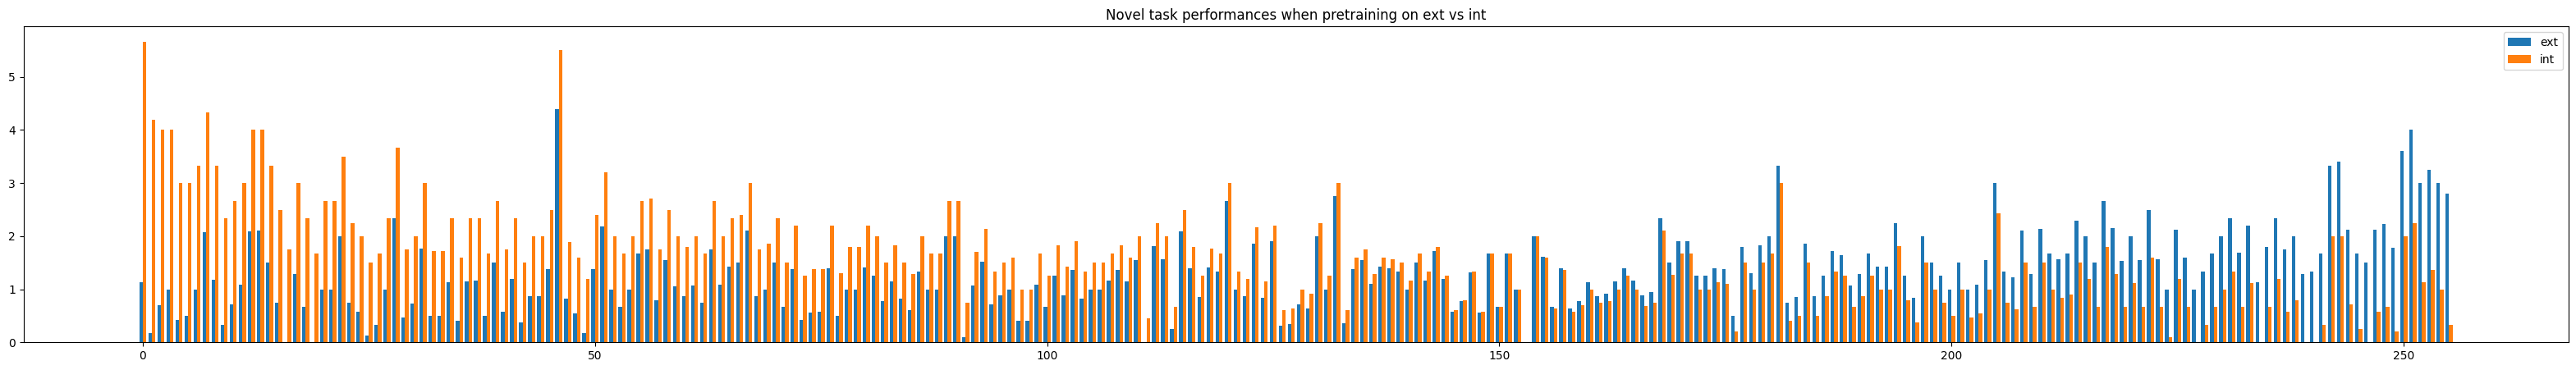

In [131]:
plt.figure(figsize=(40, 5))
plt.title('Novel task performances when pretraining on ext vs int')
x = np.arange(len(rets_ext))
plt.bar(x-0.2, mean_rets_ext[np.argsort(diff)], .4, label='ext')
plt.bar(x+0.2, mean_rets_int[np.argsort(diff)], .4, label='int')
plt.legend()
plt.show()

In [159]:
print(f'Average return on new task with ext pretraining: {mean_rets_ext.mean()}')
print(f'std error: {mean_rets_ext.std()}')
print(f'std error: {mean_rets_ext.std()/np.sqrt(256)}')
print(f'Average return on new task with int pretraining: {mean_rets_int.mean()}')
print(f'std error: {mean_rets_int.std()}')
print(f'std error: {mean_rets_int.std()/np.sqrt(256)}')
print(f'Average return on new task with random agent: {mean_rets_random.mean()}')

print(f'Intrinsic better for pretraining in {(diff<0).sum()/len(diff)*100: 2.02f}% of novel tasks')

Average return on new task with ext pretraining: 1.3326696665087265
std error: 0.7128807027969379
std error: 0.04455504392480862
Average return on new task with int pretraining: 1.5931611519990425
std error: 0.9196838913920129
std error: 0.057480243212000806
Average return on new task with random agent: 0.8072232631109221
Intrinsic better for pretraining in  58.20% of novel tasks


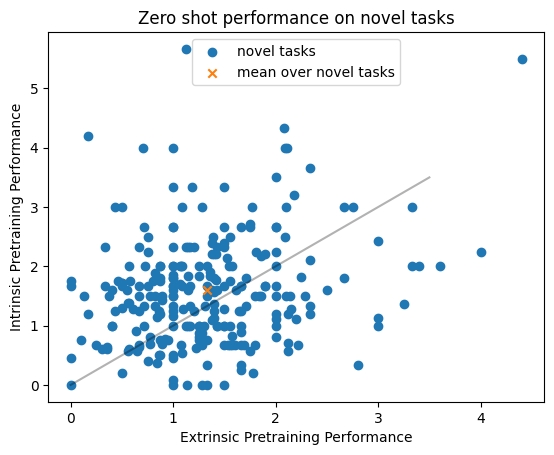

In [134]:
plt.title('Zero shot performance on novel tasks')
plt.scatter(mean_rets_ext, mean_rets_int, label='novel tasks')
plt.scatter([mean_rets_ext.mean()], [mean_rets_int.mean()], marker='x', label='mean over novel tasks')
plt.plot([0,3.5],[0,3.5], c=[0,0,0, .3])
plt.xlabel('Extrinsic Pretraining Performance')
plt.ylabel('Intrinsic Pretraining Performance')
plt.legend()
plt.show()

In [146]:
def robust_mean(x):
    mask = np.abs(x-x.mean())/x.std()<2.
    x = x[mask]
    return x.mean()

In [147]:
print(mean_rets_ext.mean(), mean_rets_int.mean())
print(mean_rets_ext.mean()-mean_rets_int.mean())
print(robust_mean(mean_rets_ext), robust_mean(mean_rets_int))
print(robust_mean(mean_rets_ext)-robust_mean(mean_rets_int))

1.3326696665087265 1.5931611519990425
-0.260491485490316
1.2410072161614993 1.4836690579068625
-0.2426618417453632


In [ ]:
load_state_dict

In [1]:
np.sign(1.)

NameError: name 'np' is not defined

In [56]:
def eval_agent(agent, level, n_envs=10, device=None):
    env = env_utils.make_env(n_envs, level_id=level)
    agent = agent.to(device)

    obs, _ = env.reset() # or just step randomly first time
    for step in tqdm(range(1100)):
        obs = torch.from_numpy(obs)
        with torch.no_grad():
            action, _, _, _, _ = agent.get_action_and_value(obs.to(device))
        obs, reward, term, trunc, info = env.step(action.tolist())
        
    rets = [e.past_returns[-1] for e in env.envs]
    print(rets)

In [57]:
args = pretrain.parser.parse_args('--pretrain-levels 1 --pretrain-obj ext --device cuda:2 --ds_size 1e9 --n_steps 100'.split())
print(args)
kwargs = pretrain.main(args)

Namespace(device='cuda:2', track=False, seed=0, env='miner', pretrain_levels=1, pretrain_obj='ext', ds_size=1000000000.0, lr=0.001, coef_entropy=0.01, n_dataset=1000000.0, batch_size=1024, n_steps=100)
Namespace(device='cuda:2', track=False, seed=0, env='miner', pretrain_levels=1, pretrain_obj='ext', ds_size=1000000000.0, lr=0.001, coef_entropy=0.01, n_dataset=1000000.0, batch_size=1024, n_steps=100)
distill_miner_00001_ext
data/distill_miner_00001_ext
n=20, n_steps=20000, len(files_flat)=1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:41<00:00, 41.75s/it]


Dataset size: torch.Size([1, 20000, 1, 4, 64, 64, 3]), torch.Size([1, 20000, 1]), torch.uint8
Dataset size: torch.Size([20000, 4, 64, 64, 3]), torch.Size([20000]), torch.uint8
Agent # parameters: 000000472615


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.87it/s, distill/loss_bc=0.712, distill/loss_entropy=0.698]

done


In [58]:
agent = kwargs['agent']

In [59]:
eval_agent(agent, 0, 10, 'cuda:1')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1100/1100 [00:05<00:00, 191.71it/s]

[2.0, 1.0, 5.0, 3.0, 4.0, 2.0, 0.0, 2.0, 0.0, 3.0]


In [38]:
        
device = 'cuda:1'
agent = models.Agent(env)
agent.load_state_dict(torch.load(f"data/miner_{21:05d}_{'ext'}/agent_{240:05d}.pt"))

eval_agent(agent, 21, device)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1100/1100 [00:02<00:00, 369.09it/s]

[10.0, 10.0, 9.0, 10.0, 8.0]


In [539]:
o = x[0, :, 0]
o.shape

torch.Size([4000, 4, 64, 64, 3])

In [541]:
for i, (o1, o2) in enumerate(zip(o[:-1], o[1:])):
    if not (o1[1:]==o2[:-1]).all().item():
        print(i)

999
1015
2015
3015
3025


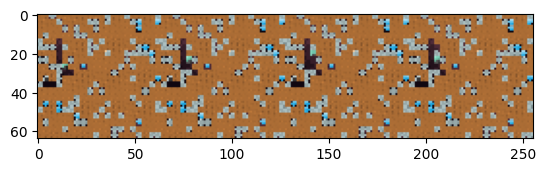

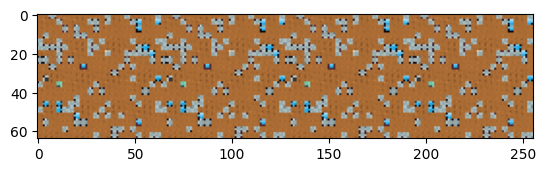

False
term
bruh wtf


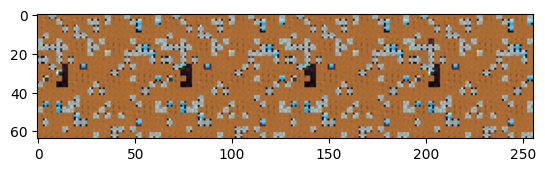

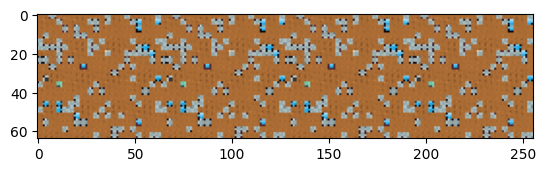

False
term
bruh wtf


In [538]:
np.random.seed(0)

env = env_utils.make_env(1)

obs, _ = env.reset()
obs = obs[0]
for i in range(50):
    nobs, _, term, trunc, _ = env.step(env.action_space.sample())
    nobs = nobs[0]
    
    if term.item():
        plt.imshow(rearrange(obs, 'b h w c -> h (b w) c'))
        plt.show()
        plt.imshow(rearrange(nobs, 'b h w c -> h (b w) c'))
        plt.show()
        print((obs[1:]==nobs[:-1]).all().item())
    
    if term.item():
        print('term')
    if not (obs[1:]==nobs[:-1]).all().item():
        print('bruh wtf')
    obs = nobs

In [5]:
parser = main.parse_args()

In [7]:
args = parser.parse_args('')

In [49]:
env = miner.make_env(10, level_id=0)
env.reset()
for i in range(1100):
    env.step(env.action_space.sample())
    

In [40]:
video = env.envs[0].past_traj_obs
video.shape

(113, 64, 64, 3)

In [48]:
wandb.log(dict(vid1=wandb.Video(rearrange(video, 't h w c->t c h w'), fps=15)))

In [5]:
def plot_rewards(envs):
    minlen = min([len(e.past_returns) for e in envs.envs])
    past_returns = np.array([e.past_returns[-minlen:] for e in envs.envs])
    mean = past_returns.mean(axis=0)
    min_ = past_returns.min(axis=0)
    max_ = past_returns.max(axis=0)
    stderr = past_returns.std(axis=0)/np.sqrt(past_returns.shape[0])
    x = np.arange(len(mean))
    plt.plot(x, mean, c='b')
    plt.plot(x, min_, c='r')
    plt.plot(x, max_, c='g')
    plt.fill_between(x, mean-stderr, mean+stderr, color=[0, 0, 1, .2])

In [7]:
env = miner.make_env(64)

r = []
r_means, r_stds = [], []
def callback(update, rewards, **kwargs):
    if update%1==0:
        e = env.envs[0]
        r_means.append(np.mean([e.past_returns[-1] for e in env.envs]))
        r_stds.append(np.std([e.past_returns[-1] for e in env.envs]))
        r.append(rewards.mean().item())
        clear_output(wait=True)
        o = kwargs['b_obs'][:, -1].cpu().numpy()
        o = o.std(axis=0).mean(axis=-1)
        heatmap = (o/o.max()*255).astype(np.uint8)
        
        plt.subplot(221)
        plt.imshow(e.first_obs)
        plt.subplot(222)
        plt.imshow(o)
        plt.show()
        
        plt.figure(figsize=(10, 3))
        plt.plot(r_means, color='b')
        mean, std = np.array(r_means), np.array(r_stds)
        plt.fill_between(range(len(mean)), mean-std, mean+std, color=[0,0, 1.,.2])
        plt.show()
    
agent = models.Agent(env)
rnd = models.RNDModel(env, (64, 64, 3))
n_params = np.sum([p.numel() for p in agent.parameters()])
print(f'Agent # parameters: {n_params:012d}')
n_params = np.sum([p.numel() for p in rnd.parameters()])
print(f'RND   # parameters: {n_params:012d}')

parser = ppo_rnd.parse_args()
args = parser.parse_args('--total-timesteps 2000000 --ext-coef 0.0 --int-coef 1.0 --num-minibatches 50 --ent-coef 0.0'.split())
args.total_timesteps
ppo_rnd.run(agent, rnd, env, args, callback_fn=callback)

Agent # parameters: 000000472615
RND   # parameters: 000001726784
Using device cpu
Start to initialize observation normalization parameter.....


100%|██████████| 10/10 [00:00<00:00, 33.44it/s]


End to initialize...


  0%|          | 0/122 [00:29<?, ?it/s]


KeyboardInterrupt: 

In [108]:
device = 'cuda:0'
env = miner.make_env(64)
agent = models.Agent(env)
agent = agent.to(device)

In [120]:
def do_rollout(agent, env, timesteps=256, device=None):
    agent = agent.to(device)
    obs, info = env.reset()
    for i in tqdm(range(timesteps)):
        with torch.no_grad():
            obs = torch.from_numpy(obs).to(device)
            action, _, _, _, _ = agent.get_action_and_value(obs)
            obs, _, _, _, _ = env.step(action.tolist())
        

In [80]:
# it takes around 3.04 seconds to generate a batch of 64x256 transitions

3.04

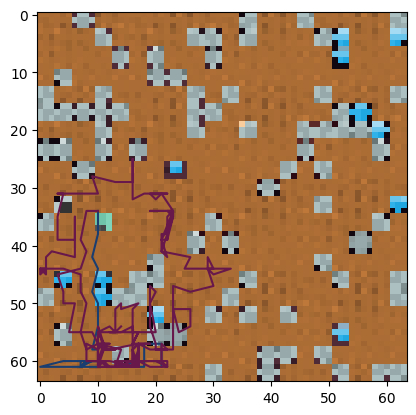

In [109]:
def calc_traj(traj_obs):
    a = traj_obs
    c = np.array([111, 196, 169])
    
    y, x = [], []
    a = np.abs(a-c).mean(axis=-1)
    for ai in a:
        yi, xi = np.unravel_index(ai.argmin(), ai.shape)
        y.append(yi)
        x.append(xi)
    y, x = np.array(y), np.array(x)
    x += np.random.randint(-1, 1, x.shape)
    y += np.random.randint(-1, 1, y.shape)
    c = np.random.rand(3)*.5

    plt.plot(x, y, c=c)

plt.imshow(env.envs[1].first_obs)

for e in env.envs[:2]:
    calc_traj(e.past_traj_obs)

In [1]:
first_obs = env.envs[0].first_obs.copy()
calc_traj_cov = lambda o:(o.std(axis=0).mean(axis=-1)>0).sum()/first_obs.mean(axis=-1).size
traj_cov = np.array([calc_traj_cov(e.past_traj_obs) for e in env.envs])
full_cov = calc_traj_cov(np.concatenate([e.past_traj_obs for e in env.envs]))

NameError: name 'env' is not defined

In [145]:
traj_cov.mean(), full_cov

(0.07220458984375, 0.68701171875)

In [11]:
env = miner.make_env(10)
env.reset()
for i in tqdm(range(1200)):
    env.step(env.action_space.sample())

100%|██████████| 1200/1200 [00:02<00:00, 597.21it/s]


In [13]:
env.envs[0].past_traj_obs.shape

(113, 64, 64, 3)

In [89]:
e = miner.make_env(1)
e.reset()
for i in tqdm(range(2000)):
    e.step([np.random.choice([3,4])])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 3562.52it/s]


In [90]:
o = e.envs[0].past_traj_obs
o.shape

(1001, 64, 64, 3)

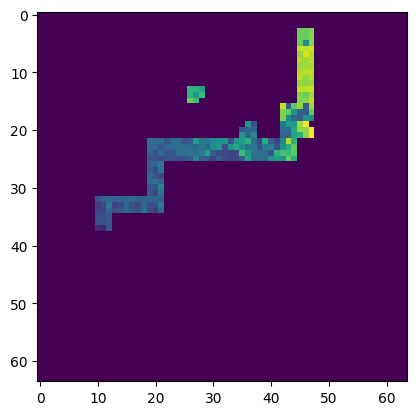

In [91]:
a = np.array([ei.past_traj_obs.std(axis=0).mean(axis=-1) for ei in e.envs])[[0]].max(axis=0)
plt.imshow(a)

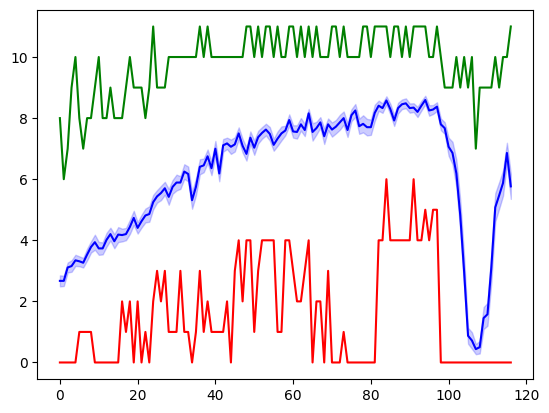

In [168]:
plot_rewards(env)

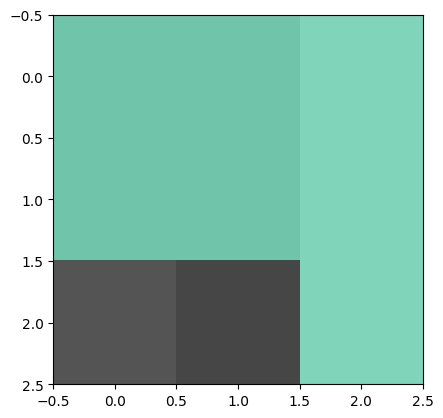

In [63]:
plt.imshow(env.envs[0].first_obs[35: 38, 10:13])

In [66]:
env.envs[0].first_obs[35: 38, 10:13][1, 1]

array([111, 196, 169], dtype=uint8)

In [169]:
np.argmax([np.max(e.past_returns) for e in env.envs])

3

In [170]:
np.argmax(env.envs[3].past_returns)

60

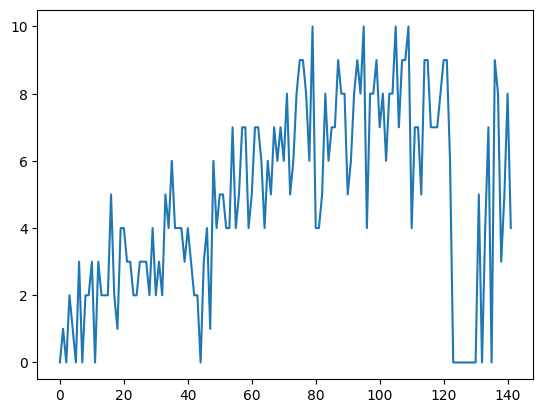

In [176]:
plt.plot(env.envs[0].past_returns)

In [177]:
env.envs[0].past_returns[125]

0.0

In [180]:
env.envs[0].past_returns[-1], env.envs[0].past_lengths[-1]

(4.0, 134)

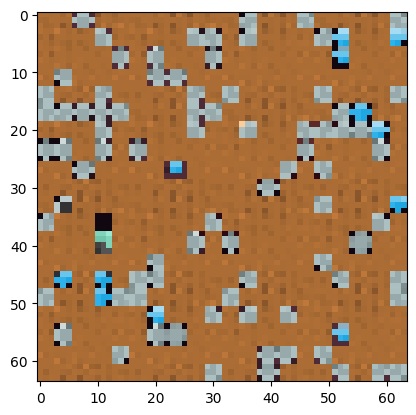

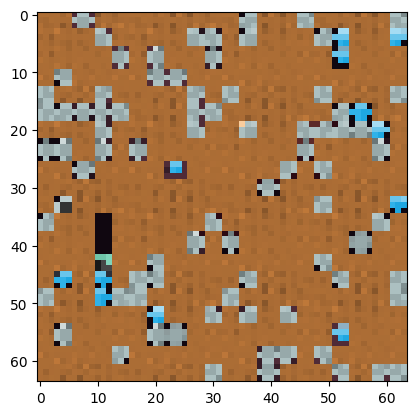

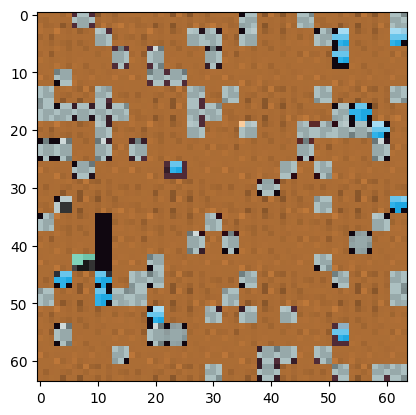

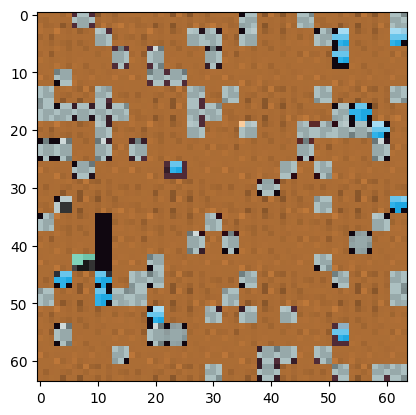

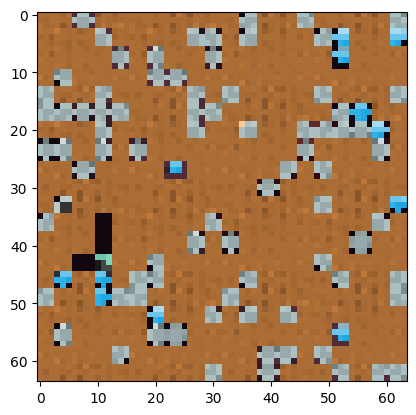

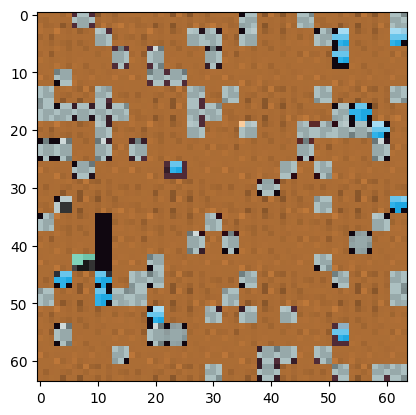

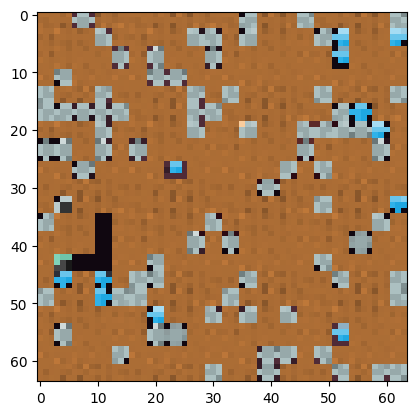

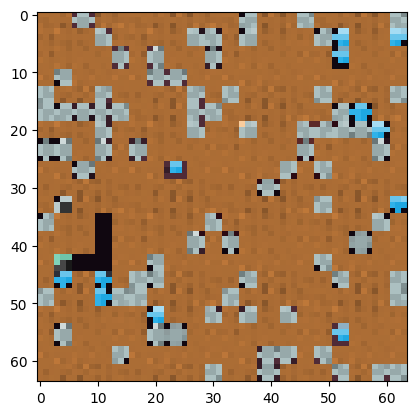

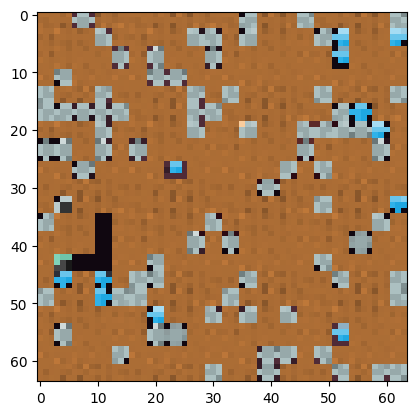

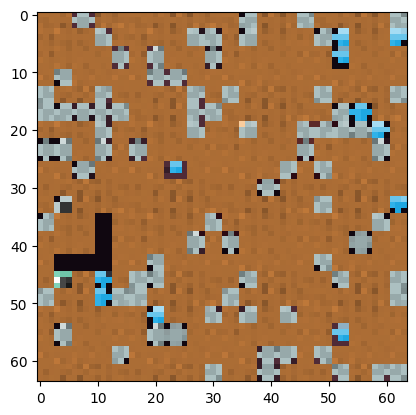

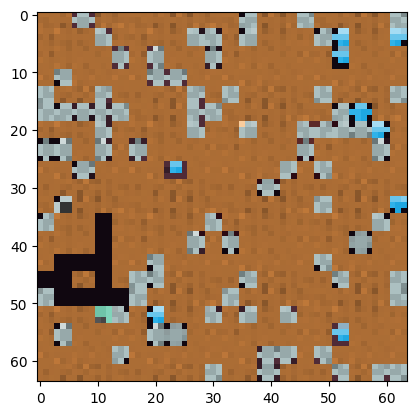

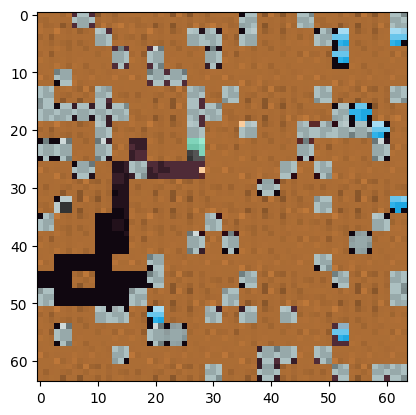

In [181]:
e = make_single_env()
obs, _ = e.reset()
for i, action in enumerate(env.envs[0].past_actions[-1]):
    obs, _, _, _, _ = e.step(action)
    if i<10 or i%50==0:
        plt.imshow(obs[-1])
        plt.show()

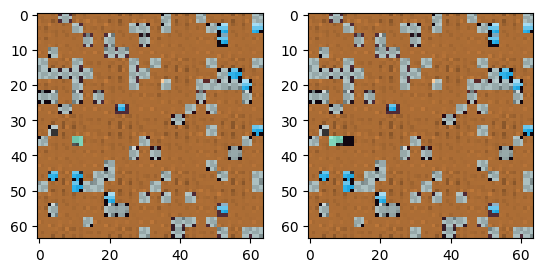

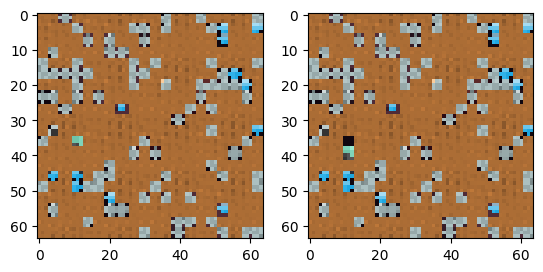

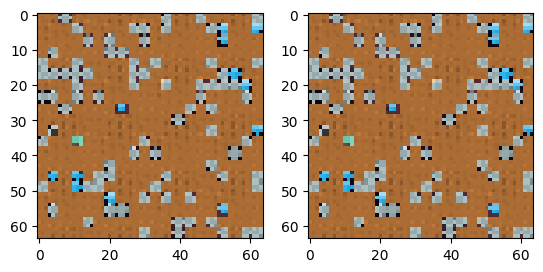

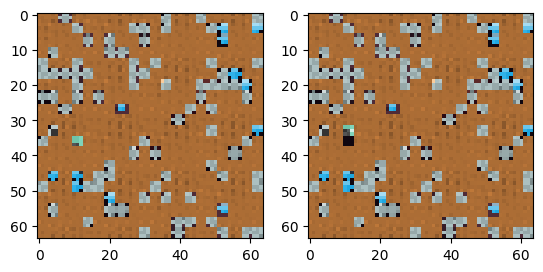

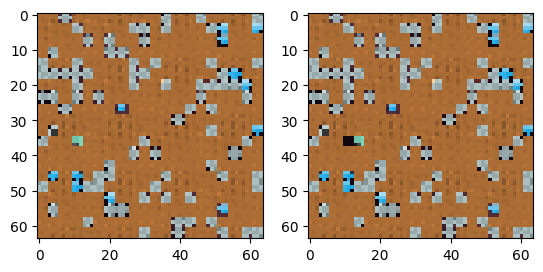

In [53]:

env = make_env(1)
obs, info = env.reset()
for action in range(env.single_action_space.n):
    env = make_env(1)
    obs, info = env.reset()
    plt.subplot(121)
    plt.imshow(obs[0, -1])
    obs, _, _, _, _ = env.step([action])
    plt.subplot(122)
    plt.imshow(obs[0, -1])
    plt.show()
    

In [ ]:
import subprocess
import re
import numpy as np

def get_mem(a):
    command = f'nvidia-smi --query-gpu=memory.{a} --format=csv'
    out = subprocess.check_output(command, shell=True)
    out = out.decode()
    out = re.findall('\d+', out)
    return np.array(out)
    
total = get_mem('total')
reserved = get_mem('reserved')
used = get_mem('used')
free = get_mem('free')
print(get_mem('total'))
print(get_mem('reserved'))
print(get_mem('used'))
print(get_mem('free'))